In [1]:
import pandas as pd
import numpy as np
import cobra
from pathlib import Path
import seaborn as sns
from fuzzywuzzy import fuzz
from matplotlib import pyplot as plt
import scipy.stats as st
import sys
sys.path.append('../code/')
import leakage
from matplotlib.colors import LogNorm, Normalize

from matplotlib import cm, colors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from collections import OrderedDict


In [2]:
# Load ecoli model
model_e = cobra.io.read_sbml_model('../models/e_coli/iML1515.xml')
model_e.solver = 'gurobi'
model_e.reactions.BIOMASS_Ec_iML1515_core_75p37M.objective_coefficient = 0
model_e.reactions.BIOMASS_Ec_iML1515_WT_75p37M.objective_coefficient = 1
m = model_e.metabolites.get_by_id('adocbl_c')
r = model_e.reactions.BIOMASS_Ec_iML1515_WT_75p37M
r.add_metabolites({m:-r.get_coefficient(m.id)})
# For some reason this model doesn't work with the full biomass function
model_e.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-26


<Solution 0.880 at 0x2a2434310>

In [3]:
model_ez = cobra.io.read_sbml_model('../models/e_coli/momentiJO1366.xml')
model_ez.id = 'moment-iJO1366'
# model_ez.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 0
# model_ez.reactions.BIOMASS_Ec_iJO1366_WT_53p95M.objective_coefficient = 1
# m = model_ez.metabolites.get_by_id('adocbl_c')
# r = model_ez.reactions.BIOMASS_Ec_iJO1366_WT_53p95M
# r.add_metabolites({m:-r.get_coefficient(m.id)})
# model_ez.optimize()
# For some reason this model doesn't work with the full biomass function

In [4]:
fn = '../models/iYL1228.xml'
model_k = cobra.io.read_sbml_model(fn)
model_k.solver = 'gurobi'

In [5]:
fn = '../models/iJN1463.xml'
model_p = cobra.io.read_sbml_model(fn)
model_p.solver = 'gurobi'
model_p.reactions.PC.lower_bound = 3


In [6]:
folder = Path('/Users/ssulheim/Library/CloudStorage/OneDrive-SINTEF/UNIL/leakage/data/Vila et al., 2023')

In [7]:
untargeted_fn = folder / 'Untargeted_LCMS.csv'
dfu = pd.read_csv(untargeted_fn)
targeted_fn = folder / 'Targeted_LCMS.csv'
dft = pd.read_csv(targeted_fn)

In [8]:
dft.head()

Metabolite_Conc               Metabolite Carbon_Source Strain  Replicate  \
0             0.00  alpha-Ketoglutaric acid     D-Glucose  Ecoli          1   
1             0.00             Butyric acid     D-Glucose  Ecoli          1   
2             0.00                   Valine     D-Glucose  Ecoli          1   
3             5.85             Pyruvic acid     D-Glucose  Ecoli          1   
4             3.94           Propionic acid     D-Glucose  Ecoli          1   

   Timepoint  
0         16  
1         16  
2         16  
3         16  
4         16

In [9]:
dft['Carbon_Source'].unique()

array(['D-Glucose', 'L-Malate', 'Acetate', 'D-Fructose', 'D-Galactose',
       'D-Ribose', 'L-Arabinose', 'Glycerol', 'Pyruvate', 'Succinate',
       'Fumarate'], dtype=object)

In [10]:
dft.Metabolite.unique()

array(['alpha-Ketoglutaric acid', 'Butyric acid', 'Valine',
       'Pyruvic acid', 'Propionic acid', 'Acetyl-ornithine', 'Alanine',
       'Acetic acid', 'Asparagine', 'beta-Hydroxybutyric acid', 'Serine',
       'Glycine', 'Succinic acid', 'Methionine', 'Fumaric acid',
       'Valeric acid', 'Citric acid', 'Lactic acid', 'Putrescine',
       'Hippuric acid'], dtype=object)

In [11]:
dft.Strain.unique()

array(['Ecoli', 'Enterobacter', 'Pputida', 'Pseudomonas'], dtype=object)

In [12]:
# idx = dft.Strain == 'Ecoli'
idx = dft.Strain == 'Enterobacter'
dft0 = dft.loc[idx, :]#['Carbon_Source', 'Metabolite','Peak_Intensity']].groupby(['Carbon_Source', 'Metabolite']).mean().reset_index()
# temp = dfu0.loc[~dfu0.isna().any(axis = 1),:]


# General analyses of the data (PCA, etc)

<Axes: xlabel='Carbon_Source', ylabel='Metabolite'>

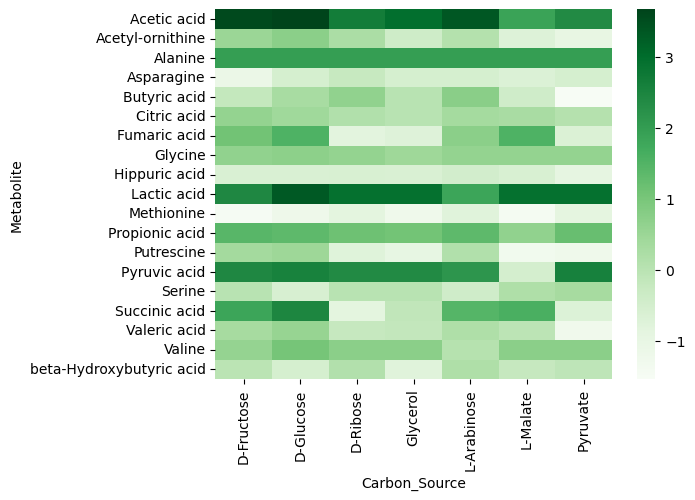

In [13]:
tidx =  (dft.Timepoint == 28) & (dft.Strain == 'Ecoli')
dfi = dft.loc[tidx,:].groupby(['Metabolite', 'Carbon_Source'])['Metabolite_Conc'].mean().reset_index()
arr = dfi.pivot(index=['Metabolite'], columns='Carbon_Source', values='Metabolite_Conc')
mask = arr == 0
arr[mask] = np.nan
arrN = arr.T.fillna(arr.mean(axis=1)).T
arrN = arrN.loc[~ arrN.isna().all(axis = 1),:]
# sns.clustermap(np.log10(arrN), mask = mask)
sns.heatmap(np.log10(arrN), cmap = 'Greens')


In [14]:
arrN

Carbon_Source              D-Fructose    D-Glucose    D-Ribose    Glycerol  \
Metabolite                                                                   
Acetic acid               3770.000000  4750.000000  457.500000  948.000000   
Acetyl-ornithine             3.215000     5.520000    1.782917    0.410500   
Alanine                     93.150000    93.150000   93.150000   93.150000   
Asparagine                   0.080000     0.298000    0.601000    0.298000   
Butyric acid                 0.667500     2.070358    4.450000    1.053000   
Citric acid                  4.195000     2.725000    1.405000    1.054500   
Fumaric acid                12.850000    34.950000    0.148500    0.185500   
Glycine                      4.545000     5.160000    4.180000    2.835000   
Hippuric acid                0.240875     0.240875    0.255000    0.240875   
Lactic acid                276.500000  2190.000000  845.333333  845.333333   
Methionine                   0.033800     0.064500    0.143500    0.061700   
Propionic acid              26.800000    21.800000   13.900000   12.000000   
Putrescine                   2.290000     2.915000    0.180500    0.109150   
Pyruvic acid               276.000000   373.000000  237.883400  237.883400   
Serine                       1.073000     0.268500    1.041500    1.073000   
Succinic acid               68.900000   307.000000    0.140000    0.740500   
Valeric acid                 2.120000     3.815000    0.631500    0.677500   
Valine                       3.965000    11.225000    5.451667    5.451667   
beta-Hydroxybutyric acid     0.974500     0.303500    1.360000    0.172000   

Carbon_Source             L-Arabinose    L-Malate    Pyruvate  
Metabolite                                                     
Acetic acid                  2275.000   73.250000  240.000000  
Acetyl-ornithine                1.245    0.199000    0.108000  
Alanine                        93.150   93.150000   93.150000  
Asparagine                      0.298    0.213000    0.298000  
Butyric acid                    5.820    0.402500    0.029150  
Citric acid                     2.220    1.975000    1.215000  
Fumaric acid                    5.505   36.000000    0.227000  
Glycine                         4.180    4.180000    4.180000  
Hippuric acid                   0.336    0.253000    0.119500  
Lactic acid                    69.500  845.333333  845.333333  
Methionine                      0.173    0.038400    0.134450  
Propionic acid                 22.000    4.405000   16.817500  
Putrescine                      1.405    0.051000    0.059000  
Pyruvic acid                  145.600    0.317000  394.500000  
Serine                          0.395    1.500000    2.160000  
Succinic acid                  29.250   39.950000    0.204000  
Valeric acid                    1.525    0.932500    0.054500  
Valine                          1.165    5.451667    5.451667  
beta-Hydroxybutyric acid        1.560    0.623000    0.832167

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pcafit = pca.fit_transform(np.log(arrN))

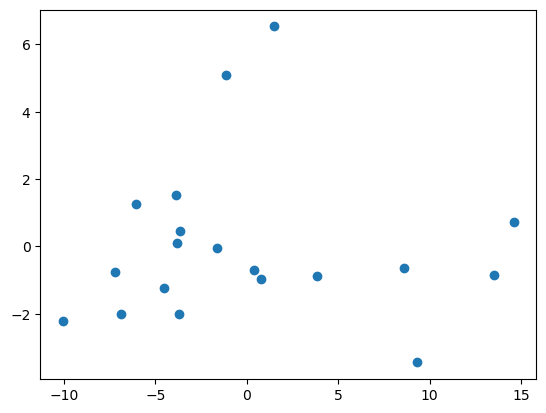

In [16]:
plt.scatter(pcafit[:,0], pcafit[:,1])

In [17]:
arrN

Carbon_Source              D-Fructose    D-Glucose    D-Ribose    Glycerol  \
Metabolite                                                                   
Acetic acid               3770.000000  4750.000000  457.500000  948.000000   
Acetyl-ornithine             3.215000     5.520000    1.782917    0.410500   
Alanine                     93.150000    93.150000   93.150000   93.150000   
Asparagine                   0.080000     0.298000    0.601000    0.298000   
Butyric acid                 0.667500     2.070358    4.450000    1.053000   
Citric acid                  4.195000     2.725000    1.405000    1.054500   
Fumaric acid                12.850000    34.950000    0.148500    0.185500   
Glycine                      4.545000     5.160000    4.180000    2.835000   
Hippuric acid                0.240875     0.240875    0.255000    0.240875   
Lactic acid                276.500000  2190.000000  845.333333  845.333333   
Methionine                   0.033800     0.064500    0.143500    0.061700   
Propionic acid              26.800000    21.800000   13.900000   12.000000   
Putrescine                   2.290000     2.915000    0.180500    0.109150   
Pyruvic acid               276.000000   373.000000  237.883400  237.883400   
Serine                       1.073000     0.268500    1.041500    1.073000   
Succinic acid               68.900000   307.000000    0.140000    0.740500   
Valeric acid                 2.120000     3.815000    0.631500    0.677500   
Valine                       3.965000    11.225000    5.451667    5.451667   
beta-Hydroxybutyric acid     0.974500     0.303500    1.360000    0.172000   

Carbon_Source             L-Arabinose    L-Malate    Pyruvate  
Metabolite                                                     
Acetic acid                  2275.000   73.250000  240.000000  
Acetyl-ornithine                1.245    0.199000    0.108000  
Alanine                        93.150   93.150000   93.150000  
Asparagine                      0.298    0.213000    0.298000  
Butyric acid                    5.820    0.402500    0.029150  
Citric acid                     2.220    1.975000    1.215000  
Fumaric acid                    5.505   36.000000    0.227000  
Glycine                         4.180    4.180000    4.180000  
Hippuric acid                   0.336    0.253000    0.119500  
Lactic acid                    69.500  845.333333  845.333333  
Methionine                      0.173    0.038400    0.134450  
Propionic acid                 22.000    4.405000   16.817500  
Putrescine                      1.405    0.051000    0.059000  
Pyruvic acid                  145.600    0.317000  394.500000  
Serine                          0.395    1.500000    2.160000  
Succinic acid                  29.250   39.950000    0.204000  
Valeric acid                    1.525    0.932500    0.054500  
Valine                          1.165    5.451667    5.451667  
beta-Hydroxybutyric acid        1.560    0.623000    0.832167

In [18]:
arr

Carbon_Source             D-Fructose  D-Glucose  D-Ribose   Glycerol  \
Metabolite                                                             
Acetic acid                3770.0000  4750.0000  457.5000  948.00000   
Acetyl-ornithine              3.2150     5.5200       NaN    0.41050   
Alanine                          NaN    93.1500       NaN        NaN   
Asparagine                    0.0800        NaN    0.6010        NaN   
Butyric acid                  0.6675        NaN    4.4500    1.05300   
Citric acid                   4.1950     2.7250    1.4050    1.05450   
Fumaric acid                 12.8500    34.9500    0.1485    0.18550   
Glycine                       4.5450     5.1600       NaN    2.83500   
Hippuric acid                    NaN        NaN    0.2550        NaN   
Lactic acid                 276.5000  2190.0000       NaN        NaN   
Methionine                    0.0338     0.0645    0.1435    0.06170   
Propionic acid               26.8000    21.8000   13.9000   12.00000   
Putrescine                    2.2900     2.9150    0.1805    0.10915   
Pyruvic acid                276.0000   373.0000       NaN        NaN   
Serine                           NaN     0.2685    1.0415        NaN   
Succinic acid                68.9000   307.0000    0.1400    0.74050   
Valeric acid                  2.1200     3.8150    0.6315    0.67750   
Valine                        3.9650    11.2250       NaN        NaN   
alpha-Ketoglutaric acid          NaN        NaN       NaN        NaN   
beta-Hydroxybutyric acid      0.9745     0.3035    1.3600    0.17200   

Carbon_Source             L-Arabinose  L-Malate   Pyruvate  
Metabolite                                                  
Acetic acid                  2275.000   73.2500  240.00000  
Acetyl-ornithine                1.245    0.1990    0.10800  
Alanine                           NaN       NaN        NaN  
Asparagine                        NaN    0.2130        NaN  
Butyric acid                    5.820    0.4025    0.02915  
Citric acid                     2.220    1.9750    1.21500  
Fumaric acid                    5.505   36.0000    0.22700  
Glycine                           NaN       NaN        NaN  
Hippuric acid                   0.336    0.2530    0.11950  
Lactic acid                    69.500       NaN        NaN  
Methionine                      0.173    0.0384    0.13445  
Propionic acid                 22.000    4.4050        NaN  
Putrescine                      1.405    0.0510    0.05900  
Pyruvic acid                  145.600    0.3170  394.50000  
Serine                          0.395    1.5000    2.16000  
Succinic acid                  29.250   39.9500    0.20400  
Valeric acid                    1.525    0.9325    0.05450  
Valine                          1.165       NaN        NaN  
alpha-Ketoglutaric acid           NaN       NaN        NaN  
beta-Hydroxybutyric acid        1.560    0.6230        NaN

In [19]:
import scipy as sp 

In [20]:
sp.cluster.hierarchy.linkage(arr)

ValueError: The condensed distance matrix must contain only finite values.

In [ ]:
arr

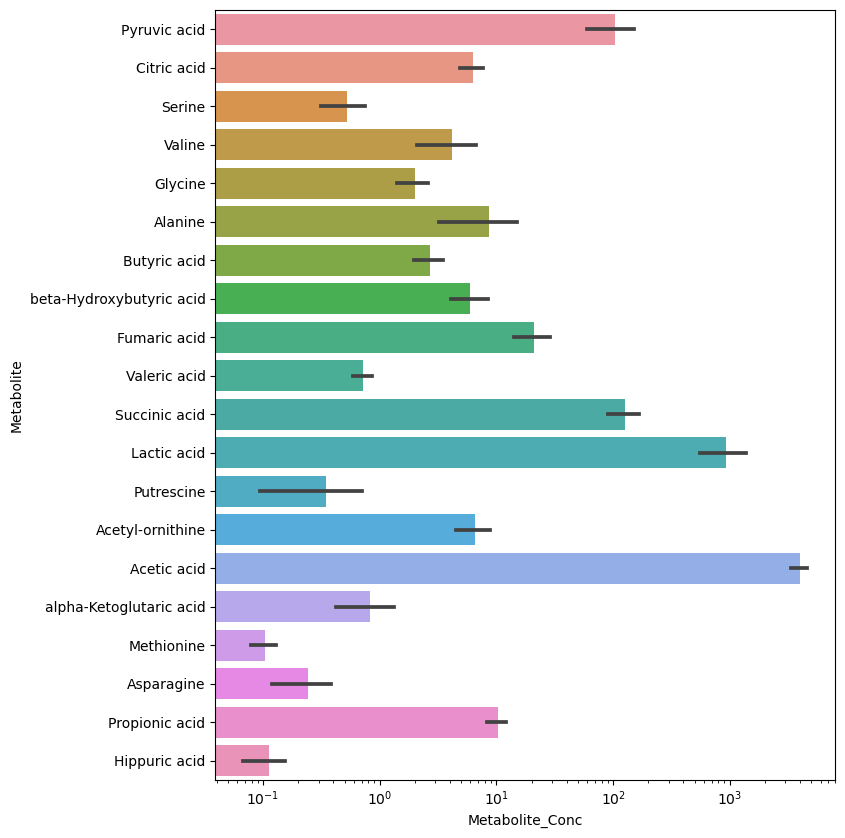

In [21]:
fig, ax = plt.subplots(1, figsize = (8,10))
sns.barplot(data = dft0, y='Metabolite', x = 'Metabolite_Conc')
ax.set_xscale('log')

# Mapping

In [22]:
translate_dict = {'alpha-Ketoglutaric acid': 'akg',
'Butyric acid': 'but',
'Valine': 'val__L',
'Pyruvic acid': 'pyr',
'Propionic acid': 'ppa',
'Acetyl-ornithine': 'acorn',
'Alanine': 'ala__L',
'Acetic acid': 'ac',
'Asparagine': 'asn__L',
'beta-Hydroxybutyric acid': 'bhb',
'Serine': 'ser__L',
'Glycine': 'gly',
'Succinic acid': 'succ',
'Methionine': 'met__L',
'Fumaric acid': 'fum',
'Valeric acid': 'pta',
'Citric acid': 'cit',
'Lactic acid': 'lac__L',
'Putrescine':  'ptrc',
'Hippuric acid': 'bgly'}
translate_dict_r = {value:key for key, value in translate_dict.items()}

# Now try to predict

In [23]:
measured_mets = []
measured_metnames = []
for key, value in translate_dict.items():
    m_id = f'{value}_c'
    try:
        m = model_e.metabolites.get_by_id(m_id)
    except KeyError:
        print(f'{key} not in model')
    else:
        measured_mets.append(m_id)
        measured_metnames.append(key)
    

beta-Hydroxybutyric acid not in model
Valeric acid not in model
Hippuric acid not in model


In [24]:
len(measured_metnames), len(translate_dict.keys())

(17, 20)

In [25]:
cs_to_exchange = {'D-Glucose': 'EX_glc__D_e',
                'D-Lactate': 'EX_lac__L_e',
                'Citrate': 'EX_cit_e',
                '2-Oxoglutarate': 'EX_akg_e',
                'Succinate': 'EX_succ_e',
                'Fumarate': 'EX_fum_e',
                'L-Malate': 'EX_mal__L_e',
                'L-Glutamine': 'EX_gln__L_e',
                'Acetate': 'EX_ac_e',
                'D-Galactose': 'EX_gal_e',
                'D-Ribose': 'EX_rib__D_e',
                'L-Arabinose': 'EX_arab__L_e',
                'Glycerol': 'EX_glyc_e',
                'D-Gluconate': 'EX_glcn_e',
                '2-Ketogluconate': 'EX_25dkglcn_e',
                'Pyruvate': 'EX_pyr_e',
                'D-Fructose': 'EX_fru_e'}


In [26]:
def get_metabolite_values(model, all_cs):
    shadow_price_dict = OrderedDict()
    growth_dict = OrderedDict()
    model.reactions.EX_glc__D_e.lower_bound = 0
    for cs in all_cs:
        ex_id = cs_to_exchange[cs]
        with model:
            try:
                r = model.reactions.get_by_id(ex_id)
            except KeyError:
                # print(f'{ex_id} not in model')
                continue
            r.lower_bound = -5
            solution = model.optimize()
            if solution.objective_value:
                mv_dict = {}
                for m_id in measured_mets:
                    m = model.metabolites.get_by_id(m_id)
                    r_ex_id = f"EX_{m_id.replace('_c','_e')}"
                    if r_ex_id == ex_id:
                        continue
                    if solution.fluxes.get(r_ex_id):
                        current_flux = solution.fluxes.get(r_ex_id)
                        if current_flux and current_flux < 1e-6:
                            print(cs, m_id, current_flux)
                            existing_flux = None
                        else:
                            existing_flux = (r_ex_id, current_flux)
                            print(cs, m_id, current_flux)
                    else:
                        existing_flux = None

                    mv =  -leakage.estimate_shadow_price_for_met(model, m, solution, delta = 0.01, existing_flux= existing_flux)
                    if not np.isfinite(mv):
                        mv = -solution.shadow_prices[m_id]
                    mv_dict[m_id] = mv
                # print(model.summary())

                growth_dict[cs] = solution.objective_value
                shadow_price_dict[cs] = mv_dict
            else:
                print(f'Model did not grow on {cs}')
    dfsp = pd.DataFrame(shadow_price_dict).T
    dfsp.columns = [x.replace('_c', '') for x in dfsp.columns]
    dfsp[dfsp < 0] = np.nan
    return dfsp

In [27]:
# dfsp

In [28]:
dft0.Timepoint.unique()

array([16, 28, 48])

In [29]:
symbols = ['o', 's', 'v', 'D', '+', '<', '>', '^', '.', '1','2','3']
cmap40 = colors.ListedColormap(cm.tab20b.colors[4:] + cm.tab20c.colors, name='tab40')

In [30]:
color_dict = {}
for i, m_id in enumerate(translate_dict.values()):
    color_dict[m_id] = cmap40(i)
                            
    

In [31]:
analyze_list = [('Ecoli', model_e),
                ('Ecoli', model_ez),
                ('Enterobacter', model_e),
                ('Enterobacter', model_k),
                ('Pputida', model_p),
                # ('Pputida', model_e),
                ('Pseudomonas', model_p)]

Ecoli iML1515


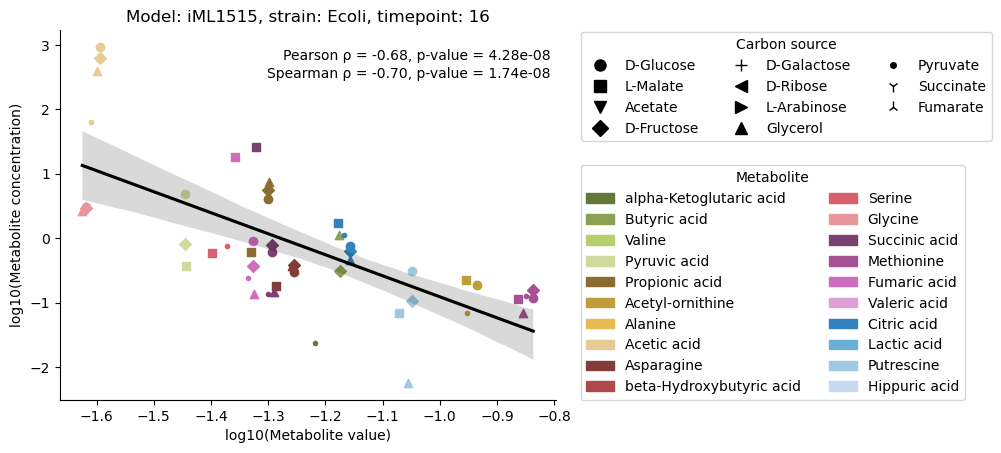

Ecoli moment-iJO1366


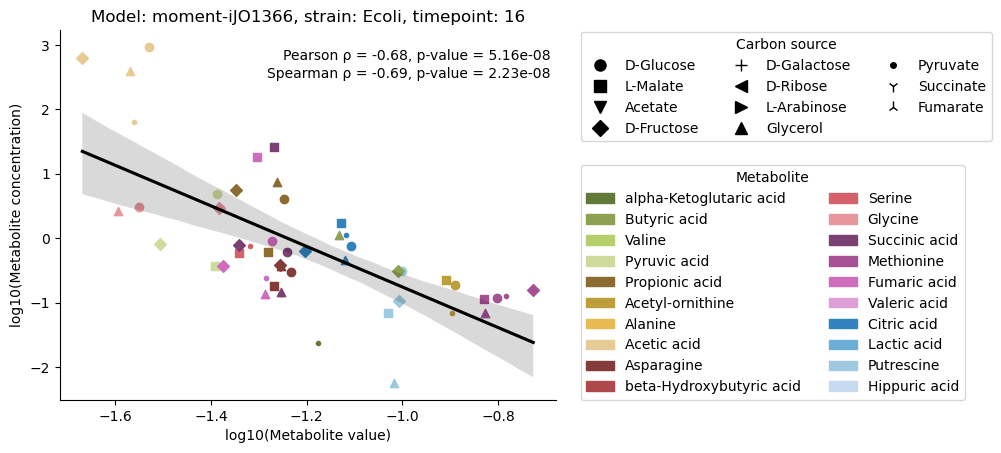

Enterobacter iML1515


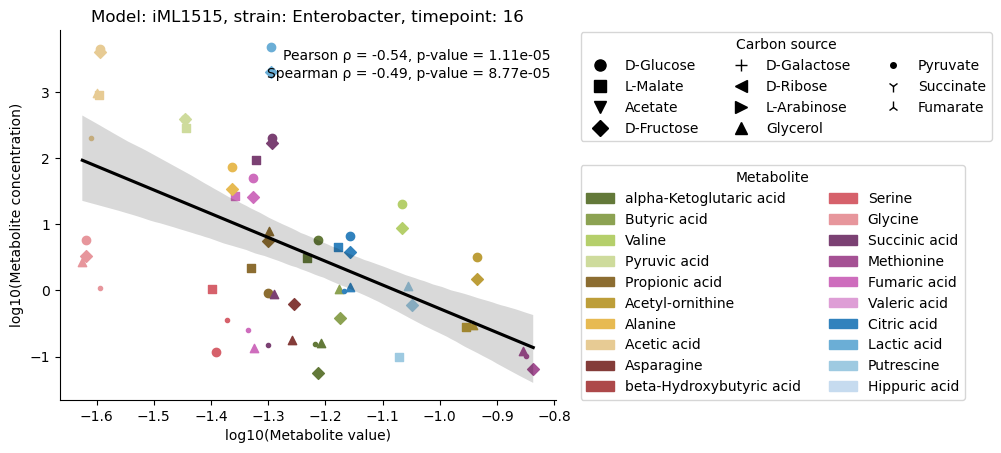

Enterobacter iYL1228


/Users/ssulheim/anaconda3/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Model did not grow on Succinate
Model did not grow on Fumarate


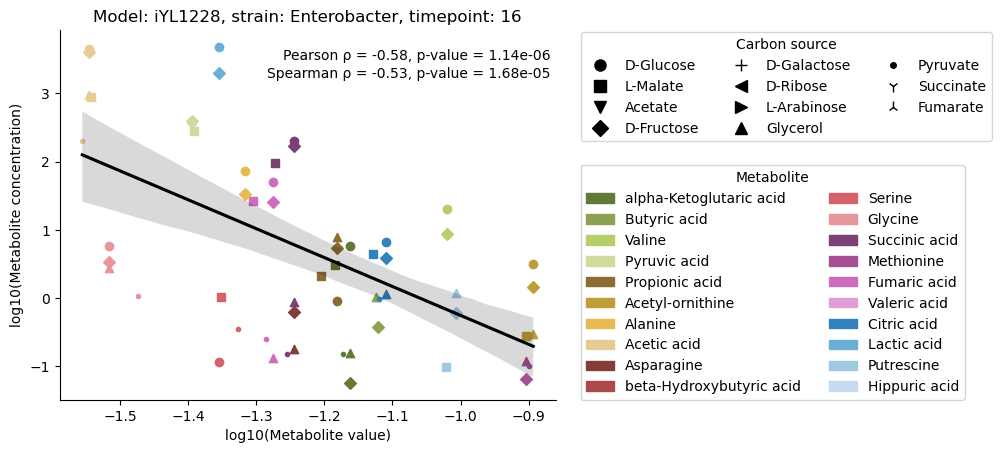

Pputida iJN1463


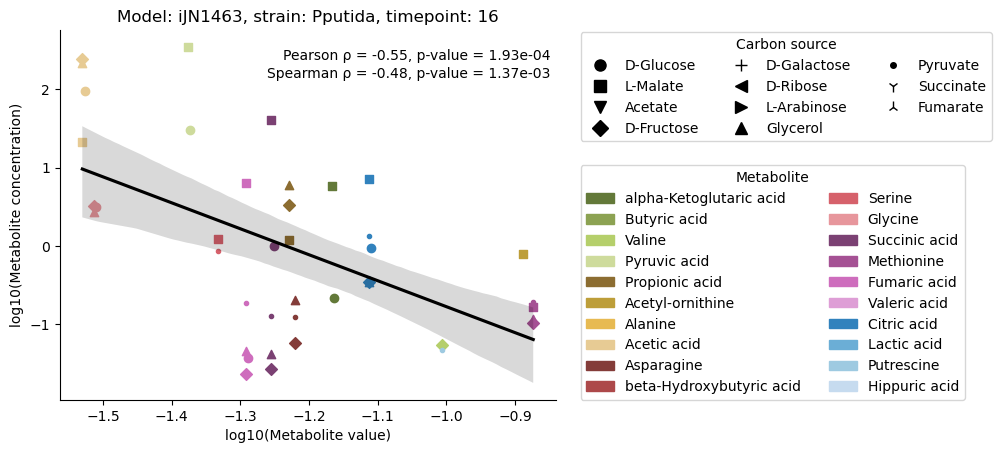

Pseudomonas iJN1463


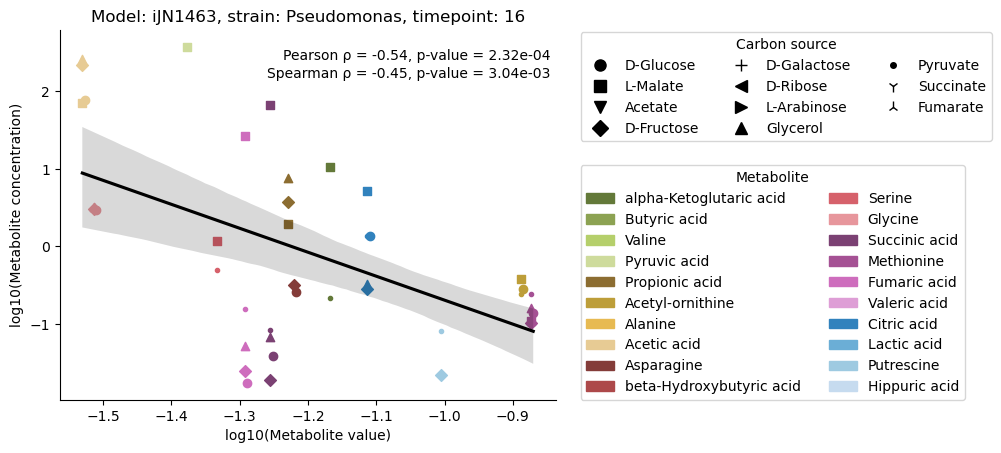

Ecoli iML1515


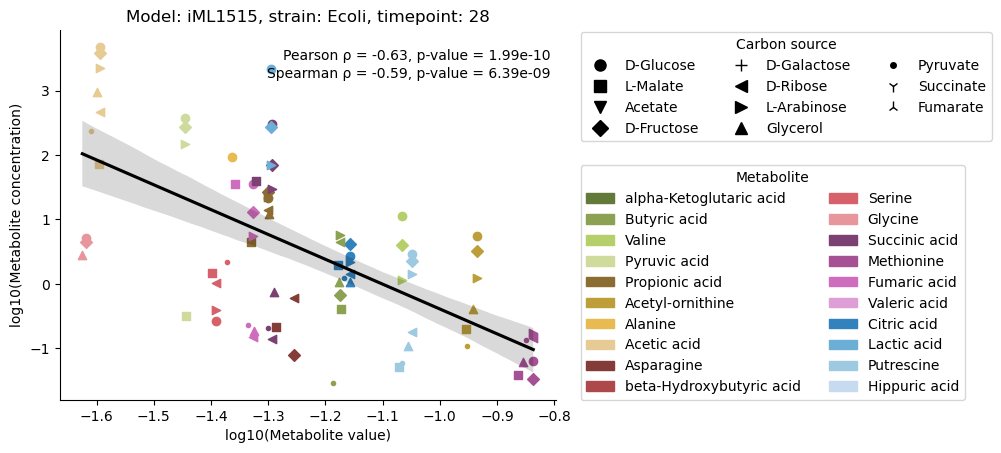

Ecoli moment-iJO1366


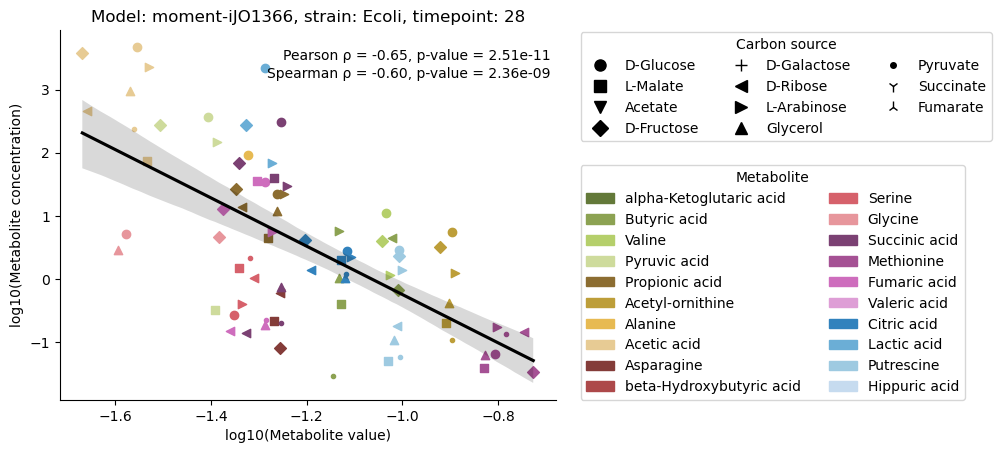

Enterobacter iML1515


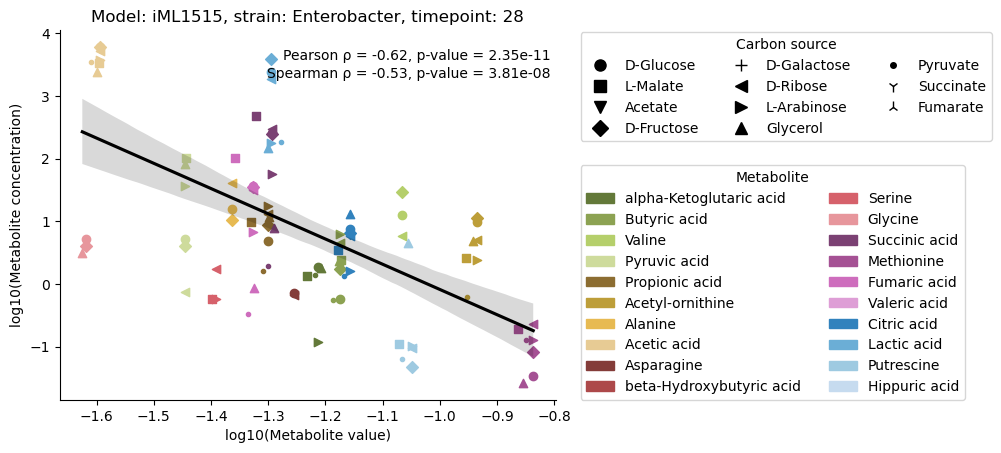

Enterobacter iYL1228


/Users/ssulheim/anaconda3/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Model did not grow on Succinate
Model did not grow on Fumarate


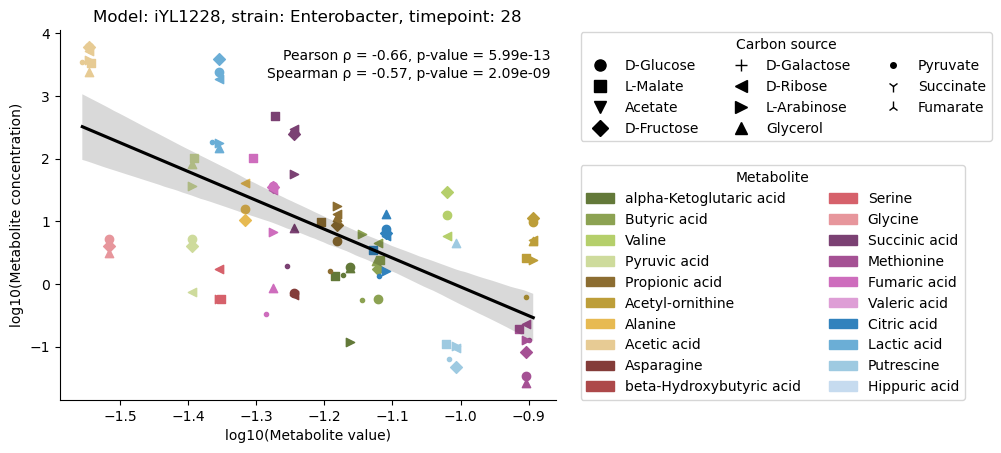

Pputida iJN1463


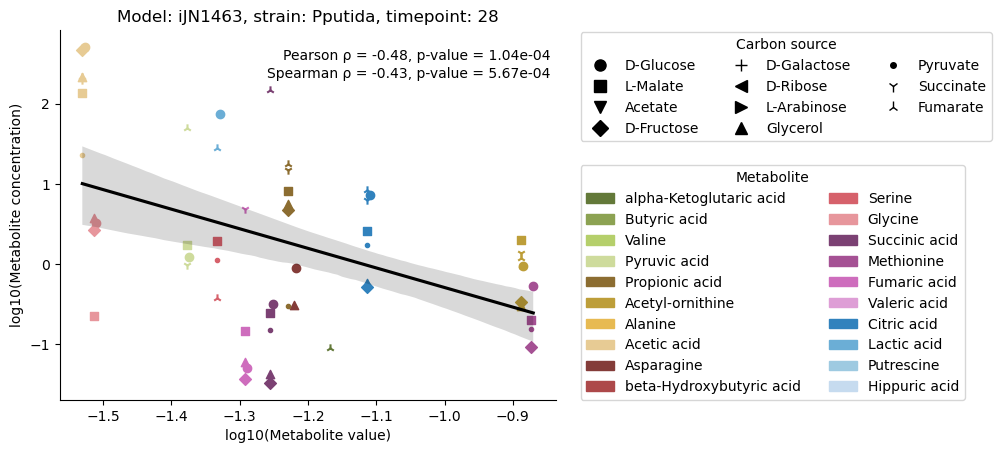

Pseudomonas iJN1463


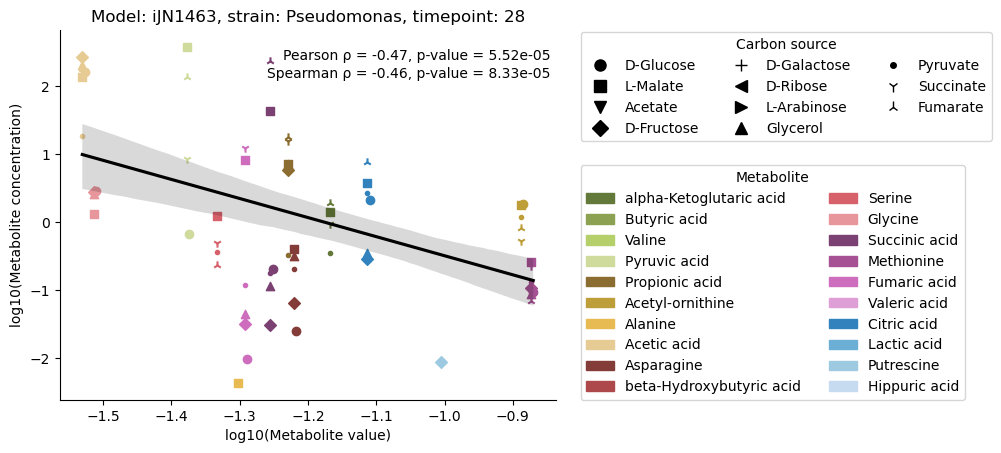

Ecoli iML1515


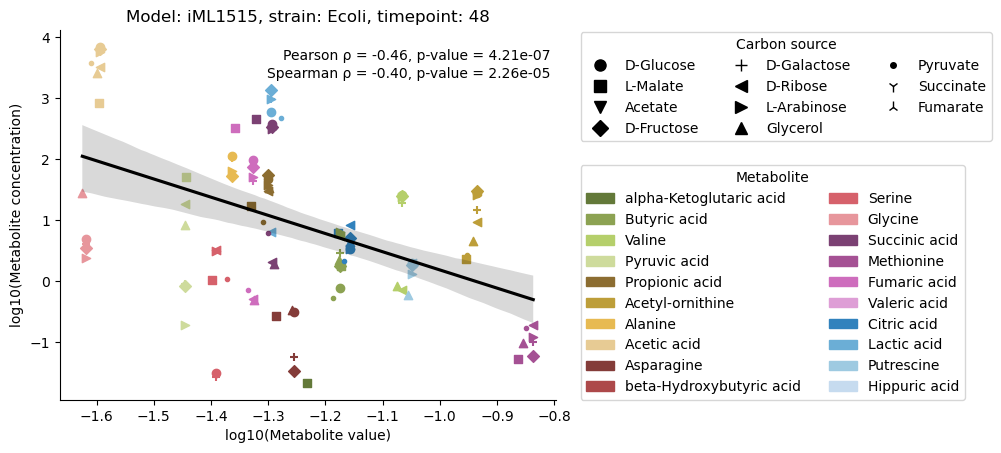

Ecoli moment-iJO1366


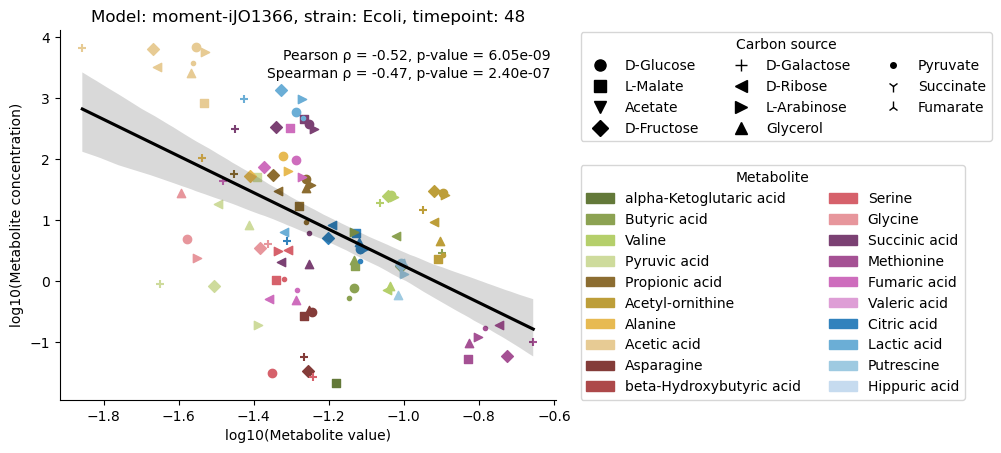

Enterobacter iML1515


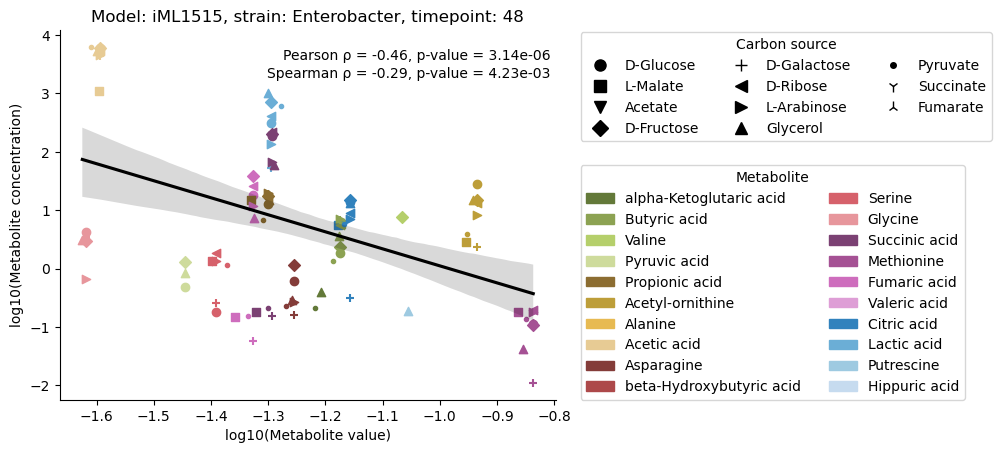

Enterobacter iYL1228


/Users/ssulheim/anaconda3/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Model did not grow on Succinate
Model did not grow on Fumarate


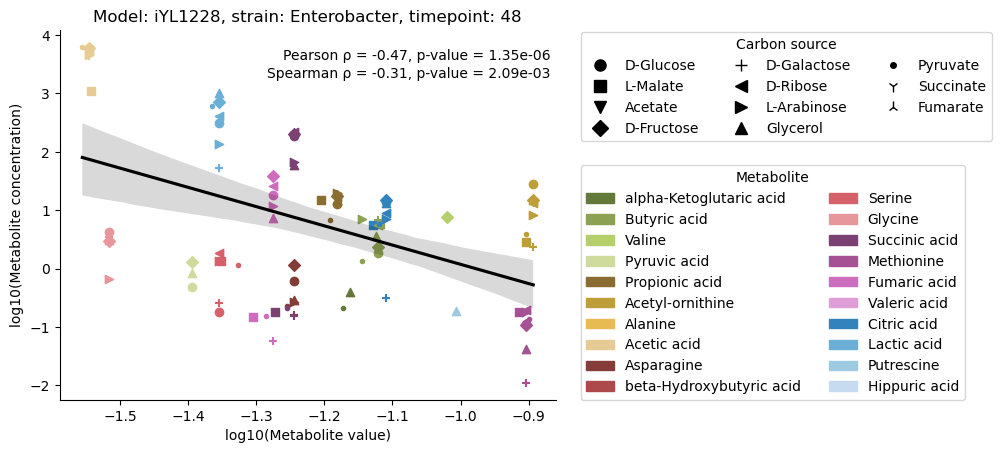

Pputida iJN1463


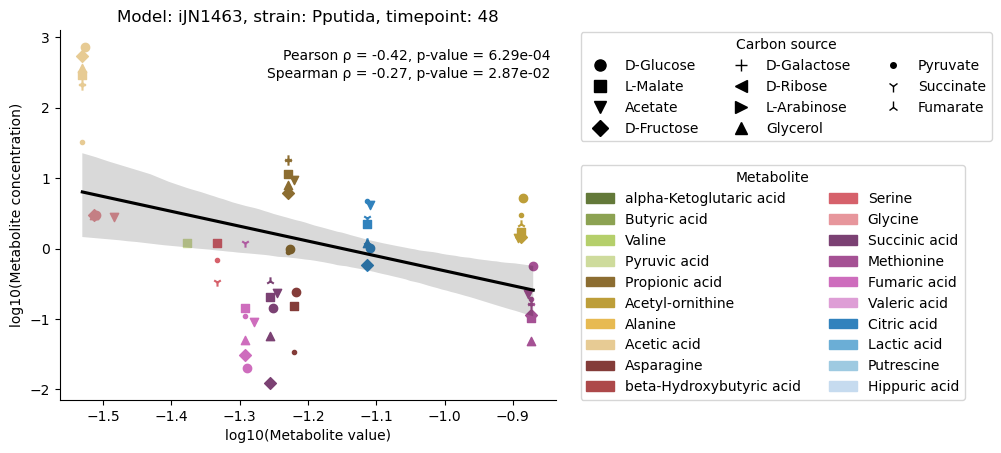

Pseudomonas iJN1463


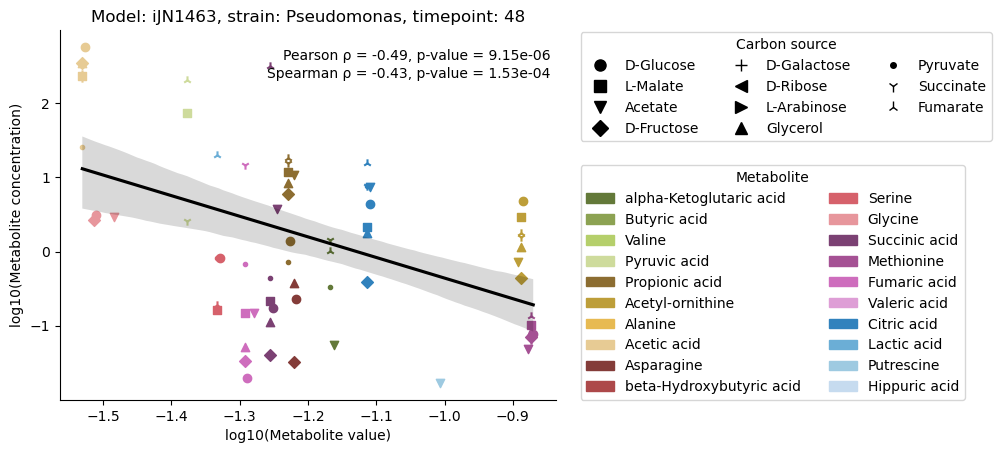

In [32]:
all_cs = dft['Carbon_Source'].unique()
# timepoint = 28
for timepoint in [16, 28, 48]:
    for strain, model in analyze_list:
        print(strain, model.id)
        idx = dft.Strain == strain
        dft0 = dft.loc[idx, :]
        dfsp = get_metabolite_values(model, all_cs)
        all_x = []
        all_y = []
        fig, ax = plt.subplots()
        for i, cs in enumerate(dft['Carbon_Source'].unique()):
            # print(cs)
            try:
                sp = dfsp.T[cs]
            except KeyError:
                continue
            x_arr = []
            y_arr = []
            idxtest = (dft0.Timepoint == timepoint) & (dft0.Carbon_Source == cs)
            if not sum(idxtest):
                continue

            for m_id in sp.index:
                # if m_id == 'ppa':
                #     continue
                spi = sp[m_id]
                if spi < 0 or np.isnan(spi):
                    continue
                m_name = translate_dict_r[m_id]
                tidx = (dft0.Metabolite == m_name) & (dft0.Carbon_Source == cs) & (dft0.Timepoint == timepoint)#
                conc_values = dft0.loc[tidx, 'Metabolite_Conc'].values
                # for y in conc_values:
                # print(cs, m_id, conc_values)
                y = np.nanmean(conc_values)
                if y > 0:
                    x_arr.append(np.log10(spi))
                    y_arr.append(np.log10(y))
                    ax.scatter(np.log10(spi), np.log10(y), label = m_id, color = color_dict[m_id], marker = symbols[i])
            # plt.legend()
            all_x += x_arr
            all_y += y_arr
        sns.regplot(x=all_x, y = all_y, ax = ax, scatter = False, color = 'k', ci = 95)

        patches = [mpatches.Patch(color=color_dict[m_id], label=translate_dict_r[m_id]) for m_id in translate_dict_r.keys()]
        patches2 = [mlines.Line2D([], [], color='k', marker=m, linestyle='None',
                                  markersize=8, label=t) for m,t in zip(symbols[:len(all_cs)], all_cs)]
        l1 = plt.legend(handles=patches, ncol = 2, loc = (1.05,0), title = 'Metabolite')
        plt.legend(handles=patches2, ncol = 3, loc = (1.05,0.7), title = 'Carbon source')
        plt.gca().add_artist(l1)

        # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
        # print(st.pearsonr(all_x, all_y))
        # print(st.spearmanr(all_x, all_y))
        plt.xlabel('log10(Metabolite value)')
        plt.ylabel('log10(Metabolite concentration)')
        sns.despine()
        prho, ppval = st.pearsonr(all_x, all_y)
        srho, spval = st.spearmanr(all_x, all_y)

        ax.text(0.99, 0.95, 'Pearson ρ = {0:.2f}, p-value = {1:.2e}'.format(prho, ppval),
             horizontalalignment='right',
             verticalalignment='top',
             transform = ax.transAxes)
        ax.text(0.99, 0.9, 'Spearman ρ = {0:.2f}, p-value = {1:.2e}'.format(srho, spval),
             horizontalalignment='right',
             verticalalignment='top',
             transform = ax.transAxes)
        ax.set_title(f'Model: {model.id}, strain: {strain}, timepoint: {timepoint}')
        plt.show()


# Are shadow prices indicative of release rate differences between environments?

In [ ]:
# for timepoint in [16, 28, 48]:
timepoint = 28
# for strain, model in analyze_list:
strain = 'Ecoli'
model = model_ez
# print(strain, model.id)
idx = dft.Strain == strain
dft0 = dft.loc[idx, :]
dfsp = get_metabolite_values(model, all_cs)


In [460]:
carbon_sources = dft0.Carbon_Source.unique()
# cs = carbon_sources[0]

In [462]:
for m_id in dfsp.columns:
    mvs = dfsp[m_id]
    m_name = translate_dict_r[m_id]
    concentrations = []
    metabolite_values = []
    for cs in carbon_sources:
        idxi = (dft0.Timepoint == timepoint) & (dft0.Carbon_Source == cs) & (dft0.Metabolite == m_name)
        dfti = dft0.loc[idxi,:]
        if np.isfinite(dfti.Metabolite_Conc.mean()) and np.isfinite(mvs[cs]):
            concentrations.append(dfti.Metabolite_Conc.mean())
            metabolite_values.append(mvs[cs])
    # print(concentrations, metabolite_values)
    nonzero_conc = [x for x in concentrations if x > 0]
    print(concentrations)
    print(metabolite_values)
    if len(nonzero_conc) > 3:
        prho, ppval = st.pearsonr(concentrations, metabolite_values)
        srho, spval = st.spearmanr(concentrations, metabolite_values)
        print(m_id, prho, ppval, srho, spval, len(concentrations))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.06724767697198208, 0.065823633429965, 0.054747474742861124, 0.05675981059533597, 0.0672464401078543, 0.06816264291476526, 0.06661132118118418]
[0.0, 0.4025, 0.6675, 4.45, 5.82, 1.053, 0.02915]
[0.07365132796798474, 0.07431557990385951, 0.09813096196445403, 0.09503900879021798, 0.07365268660546659, 0.07365618846110833, 0.07150921244441227]
but 0.20427745765583544 0.6603979922600177 0.42857142857142866 0.337368311085824 7
[11.225000000000001, 0.0, 3.965, 0.0, 1.165, 0.0, 0.0]
[0.09254566471502135, 0.09354717636661514, 0.09056269418555307, 0.09025760099012348, 0.09420936861290197, 0.09207203901147043, 0.09305993400309798]
[373.0, 0.317, 276.0, 0.0, 145.6, 0.0]
[0.03926408081203481, 0.040639560252075935, 0.031087342093194525, 0.032015330590606794, 0.040969668132390114, 0.03874866594908433]
pyr -0.085333057863467 0.8723110993811289 0.11595420713048968 0.826848213385815 6
[21.8, 4.404999999999999, 26.799999999999997, 13.899999999999999, 22.0, 12.0, 0.0]

In [449]:
concentrations

[0.0, 0.0, 0.0, nan, nan, nan, 0.0, 0.0237]

In [443]:
mvs

D-Glucose      0.067248
L-Malate       0.065824
Acetate        0.066642
D-Fructose     0.054747
D-Galactose    0.043043
D-Ribose       0.056760
L-Arabinose    0.067246
Glycerol       0.068163
Pyruvate       0.066611
Succinate      0.065318
Fumarate       0.065856
Name: akg, dtype: float64

In [447]:
dfti

Metabolite_Conc               Metabolite Carbon_Source Strain  \
2402           0.0474  alpha-Ketoglutaric acid      Pyruvate  Ecoli   
2435           0.0000  alpha-Ketoglutaric acid      Pyruvate  Ecoli   

      Replicate  Timepoint  
2402          1         16  
2435          2         16

In [436]:
dft0.Carbon_Source.unique()

array(['D-Glucose', 'L-Malate', 'D-Fructose', 'D-Galactose', 'D-Ribose',
       'L-Arabinose', 'Glycerol', 'Pyruvate'], dtype=object)

In [579]:
rel_std = dfsp.std()/dfsp.mean()
std_log = np.log10(dfsp).std()#/np.log10(dfsp).mean()

In [582]:
log_sp = np.log10(dfsp)

In [583]:
dfspN = (dfsp-dfsp.mean())/dfsp.std()

In [584]:
log_spN = (log_sp-log_sp.mean())/log_sp.std()

In [585]:
res_dict = resultN.T.to_dict()
sp_dict = dfspN.T.to_dict()
spl_dict = log_spN.T.to_dict()

In [586]:
resultN

Metabolite       2',4'-Dihydroxyacetophenone  2,3-Diaminopropionic acid  \
Carbon_Source                                                             
2-Ketogluconate                     1.084062                  -0.163698   
Acetate                            -0.990420                  -0.940725   
Citrate                             0.149919                  -0.700911   
D-Fructose                          1.234588                   1.278289   
D-Galactose                         0.645832                   1.112152   
D-Gluconate                         1.104784                   0.701518   
D-Glucose                           2.207946                   2.373666   
D-Lactate                          -0.868249                  -0.558648   
D-Ribose                           -0.511766                  -0.614242   
Fumarate                           -0.990420                  -0.958574   
Glycerol                           -0.770996                   0.012504   
L-Arabinose                         0.576224                   1.339795   
L-Glutamine                        -0.977427                  -0.709046   
L-Malate                           -0.990420                  -0.468412   
Pyruvate                            0.056483                  -0.745094   
Succinate                          -0.960143                  -0.958574   

Metabolite       2-Hydroxybutyric acid  2-Hydroxyglutaric acid  \
Carbon_Source                                                    
2-Ketogluconate              -0.101302                0.003737   
Acetate                      -1.027411               -1.080151   
Citrate                      -0.697773               -0.477456   
D-Fructose                    1.290932                0.634215   
D-Galactose                   1.234724                2.360135   
D-Gluconate                   0.382217                0.708699   
D-Glucose                     2.298829                1.953064   
D-Lactate                    -0.343160               -0.963015   
D-Ribose                     -0.353029               -0.221432   
Fumarate                     -1.008893               -1.016826   
Glycerol                     -0.306796               -0.044428   
L-Arabinose                   1.505293                0.676273   
L-Glutamine                  -0.671801               -0.458724   
L-Malate                     -0.524485               -0.425836   
Pyruvate                     -0.648809               -0.604706   
Succinate                    -1.028535               -1.043550   

Metabolite       2-Ketobutyric acid/Succinic acid semialdehyde  \
Carbon_Source                                                    
2-Ketogluconate                                      -0.004557   
Acetate                                              -0.971273   
Citrate                                              -0.650894   
D-Fructose                                            1.915383   
D-Galactose                                           1.213949   
D-Gluconate                                           0.093186   
D-Glucose                                             1.800165   
D-Lactate                                            -0.896196   
D-Ribose                                             -0.506457   
Fumarate                                             -0.938264   
Glycerol                                             -0.069998   
L-Arabinose                                           1.580547   
L-Glutamine                                          -0.596259   
L-Malate                                             -0.467305   
Pyruvate                                             -0.531551   
Succinate                                            -0.970477   

Metabolite       2/3-Phosphoglyceric acid  3-(2-Hydroxyphenyl)propanoic acid  \
Carbon_Source                                                                  
2-Ketogluconate                 -0.779796                           0.639184   
Acetate                        

In [544]:
import scipy.stats as st

In [545]:
dfspN.columns

Index(['23dappa_c', '2obut_c', '3pg_c', 'dhpppn_c', '34hpp_c', 'amp_c',
       'ala__L_c', 'cit_c', 'dgsn_c', 'dtbt_c', 'fad_c', 'f6p_c', 'fum_c',
       'glcn_c', 'gam6p_c', 'gua_c', 'gmp_c', 'hcys__L_c', 'hxan_c',
       'aacald_c', 'ins_c', 'imp_c', 'lac__L_c', 'mal__D_c', 'acglu_c',
       'nad_c', 'orot_c', 'akg_c', 'phpyr_c', 'pyr_c', 'ura_c', 'xan_c',
       'xtsn_c'],
      dtype='object')

In [587]:
carbon_sources = [x for x in cs_to_exchange.keys() if x in shadow_price_dict.keys() and x in res_dict.keys()]

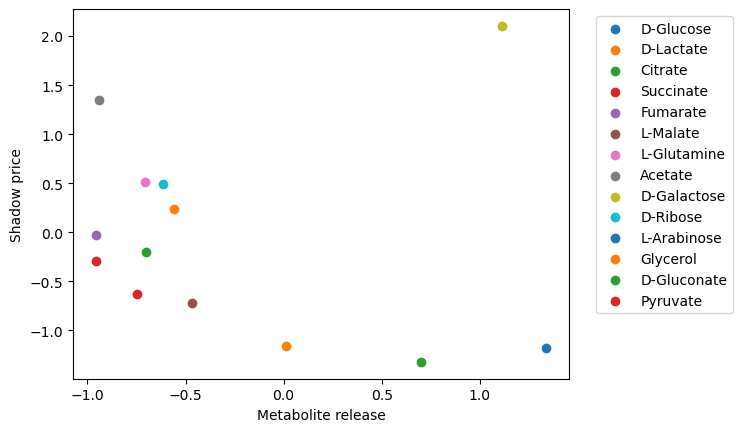

2,3-Diaminopropionic acid
-0.12441526933986873 0.685502816813651 -0.34112824568605227 0.2540107344193662
23dappa_c 0.6322 0.3438


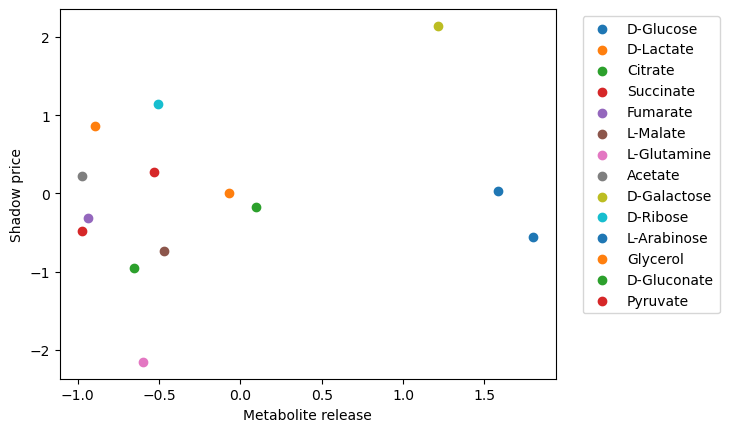

2-Ketobutyric acid/Succinic acid semialdehyde
0.2211684053636957 0.44733361629563345 0.09010989010989012 0.7593388378159541
2obut_c 0.198 0.0909


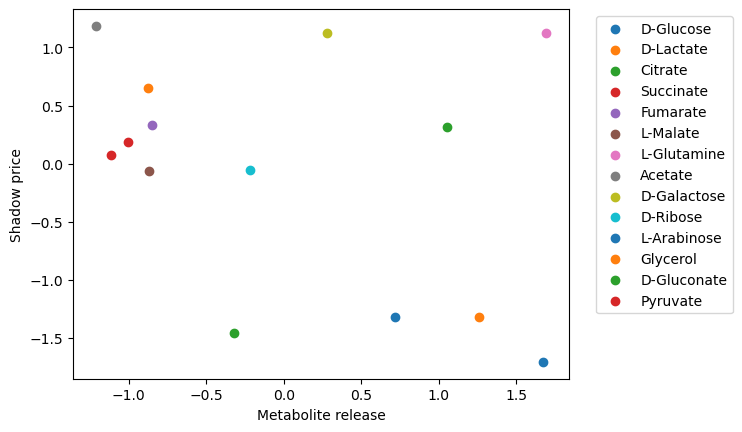

2/3-Phosphoglyceric acid
-0.3517101742449254 0.2175148863421093 -0.3054945054945055 0.2881698858754571
3pg_c 0.4241 0.2431


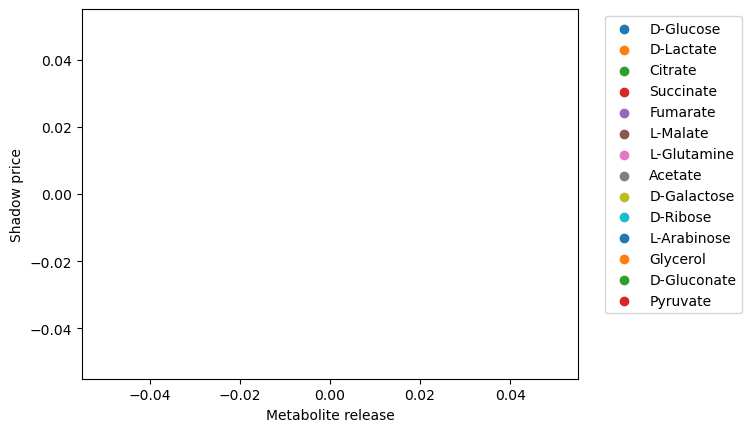

3-(2-Hydroxyphenyl)propanoic acid


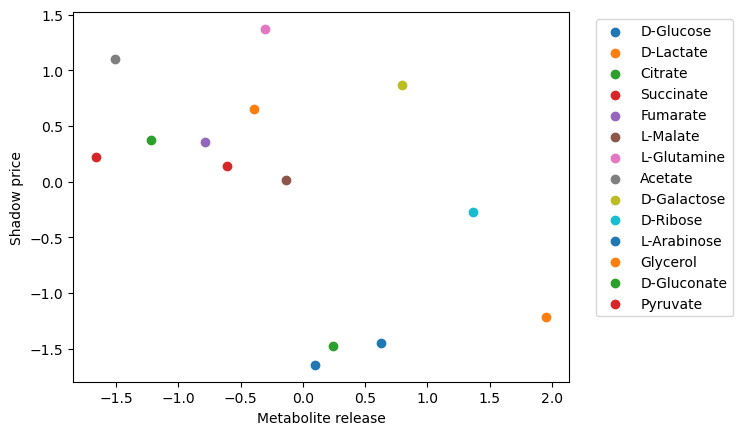

4-Hydroxyphenylpyruvic acid
-0.5192512030078223 0.05706457308572688 -0.49890109890109896 0.06936352739715487
34hpp_c 0.2903 0.1443


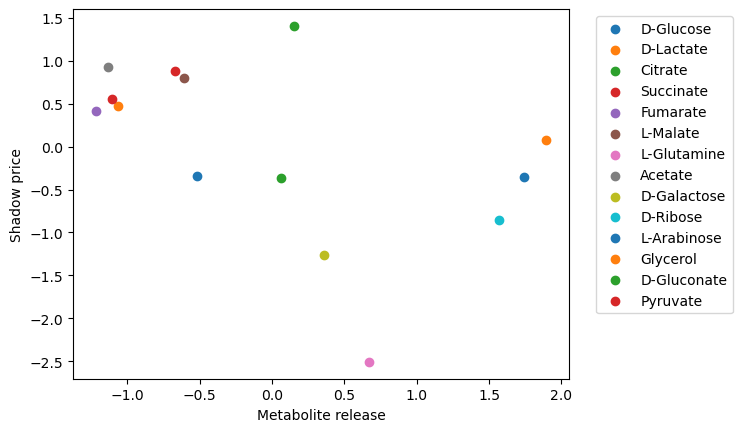

Adenosine monophosphate
-0.4925535264273299 0.07355827484500405 -0.5780219780219781 0.030383014145236958
amp_c 0.0595 0.0267


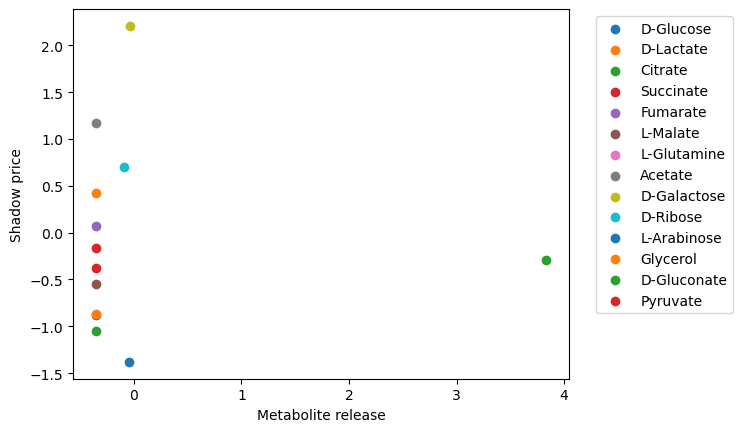

Alanine/Sarcosine
-0.026858607529740827 0.9305946108565869 0.1744848557072916 0.5685912573644221
ala__L_c 0.4722 0.2127


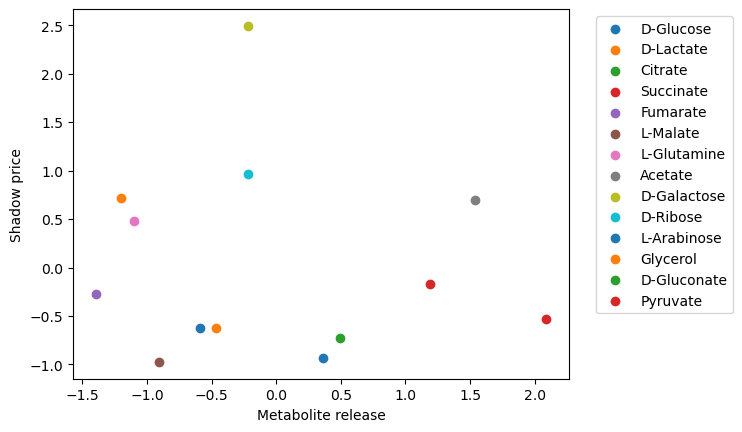

Citric/Isocitric acid
-0.08875647088806149 0.7730867341350731 -0.03846153846153846 0.9007243023389337
cit_c 0.4431 0.185


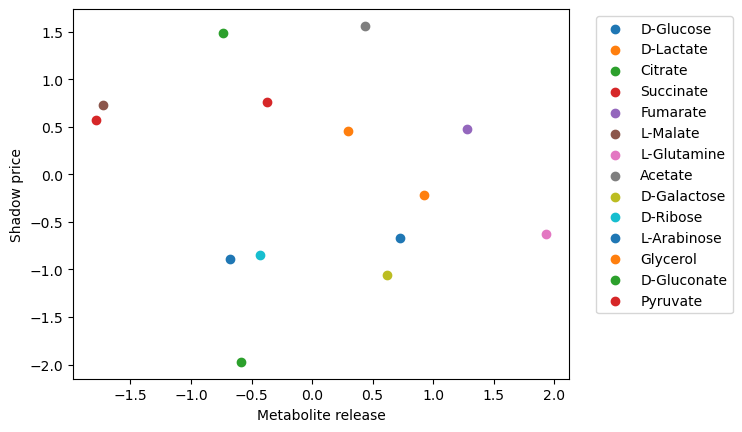

Deoxyguanosine
-0.18273577098637503 0.5317817765162729 -0.1824175824175824 0.5325088185186945
dgsn_c 0.0613 0.0268


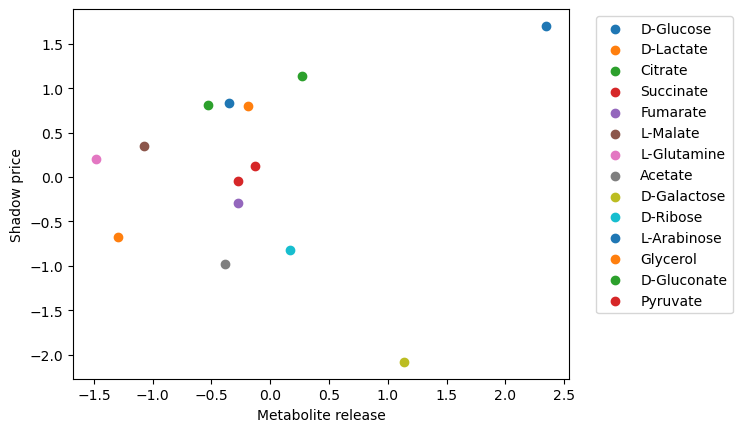

Dethiobiotin
0.1364805259972007 0.6417597153609818 0.0945054945054945 0.7479382611415478
dtbt_c 0.1263 0.0568


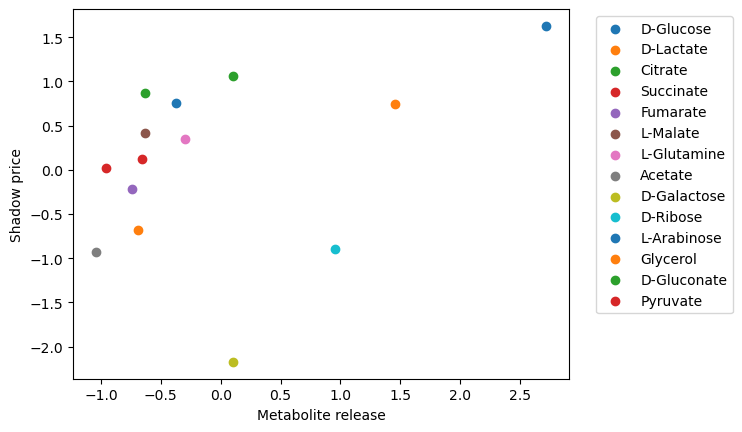

FAD
0.35478850774437953 0.2132354878018699 0.45054945054945056 0.10593278527264058
fad_c 0.1781 0.0835


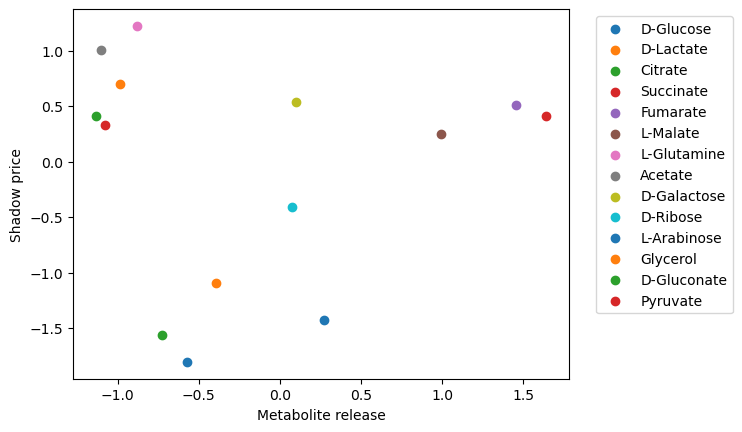

Fructose 6-phosphate
0.004375105400506926 0.9881568307897977 -0.2087912087912088 0.4737788373098136
f6p_c 0.4697 0.3148


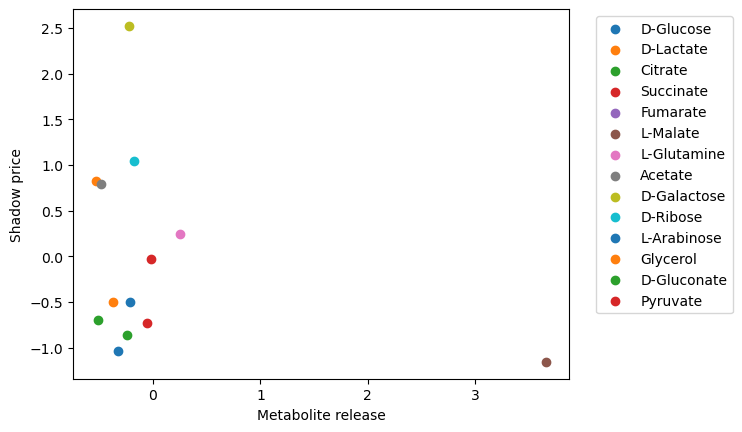

Fumaric acid
-0.32070134490616387 0.28536625037414215 -0.1868131868131868 0.5411235235098939
fum_c 0.4324 0.1765


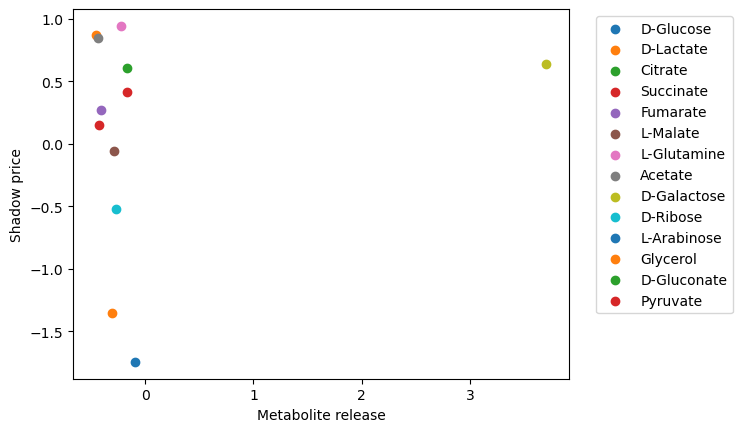

Gluconic acid
0.1556712102815822 0.629014398692699 -0.17482517482517487 0.5868236643627043
glcn_c 0.4913 0.4376


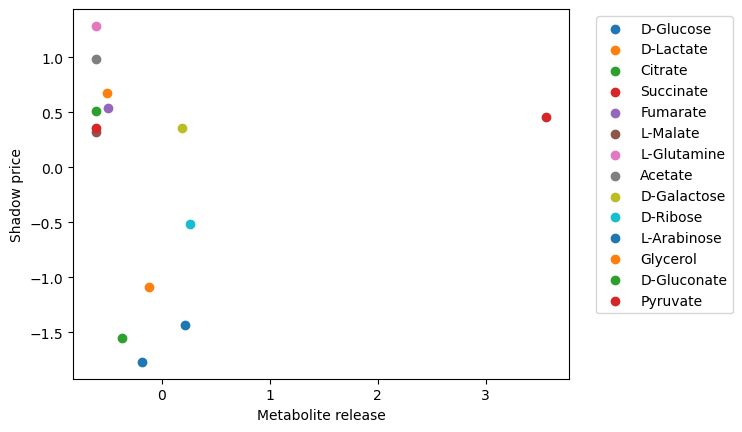

Glucosamine 6-phosphate
-0.03410239251199521 0.9078624437831757 -0.4877636220720025 0.07684048587548296
gam6p_c 0.3408 0.1829


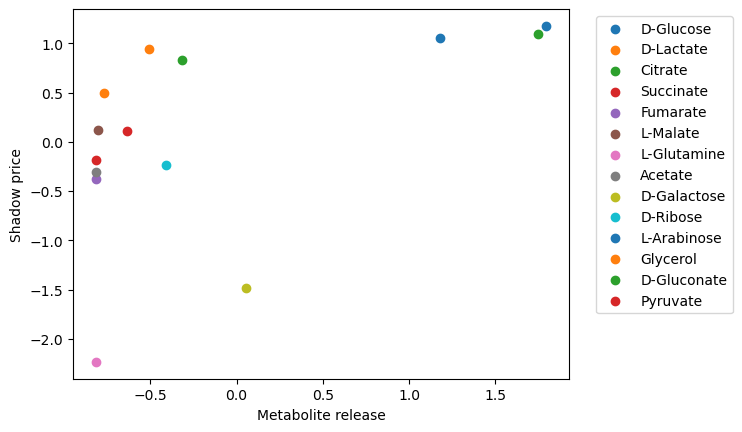

Guanine
0.5289712722523252 0.05178229765275612 0.6867090574230528 0.006673184188524621
gua_c 0.1051 0.0479


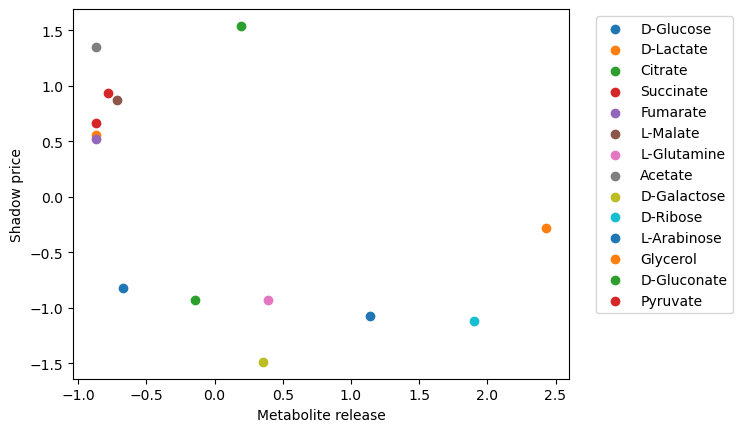

Guanosine monophosphate
-0.5380347983475035 0.0471849946721513 -0.6067041186941534 0.02142019683592601
gmp_c 0.0491 0.0214


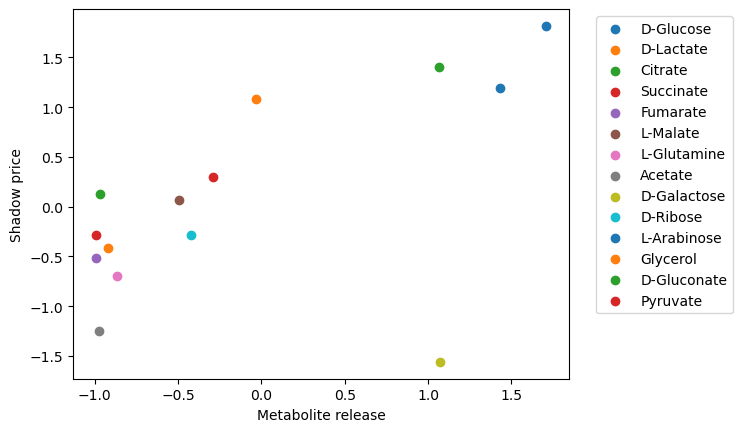

Homocystine
0.5848751059217281 0.02802557034020623 0.5786582159449335 0.030158146162140163
hcys__L_c 0.1318 0.0568


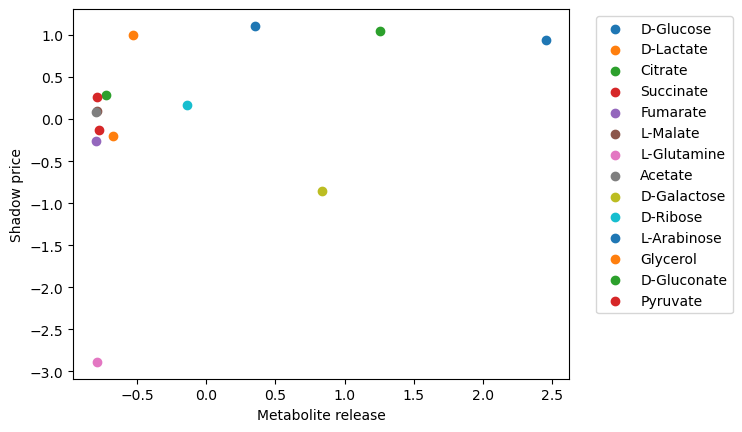

Hypoxanthine
0.3743534431009647 0.18727543059304763 0.4769230769230769 0.0846484341946868
hxan_c 0.0946 0.0449


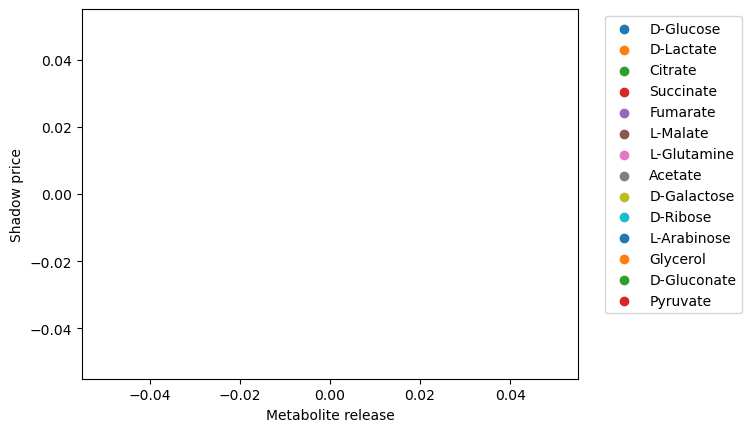

Indoleacetaldehyde


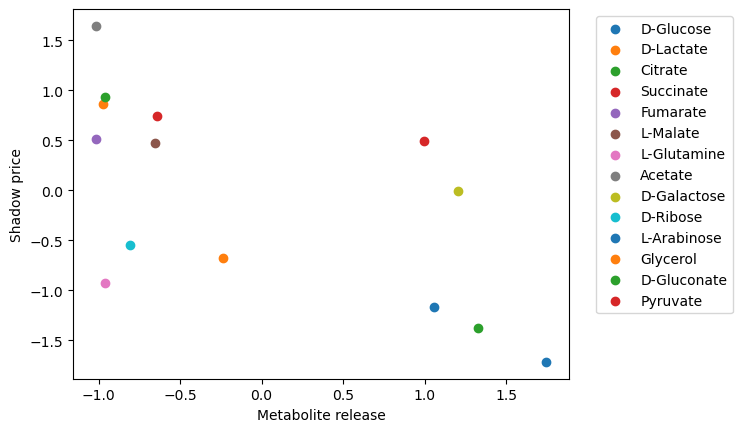

Inosine
-0.6307152894507057 0.015589785115592364 -0.745054945054945 0.002230037316742075
ins_c 0.0728 0.032


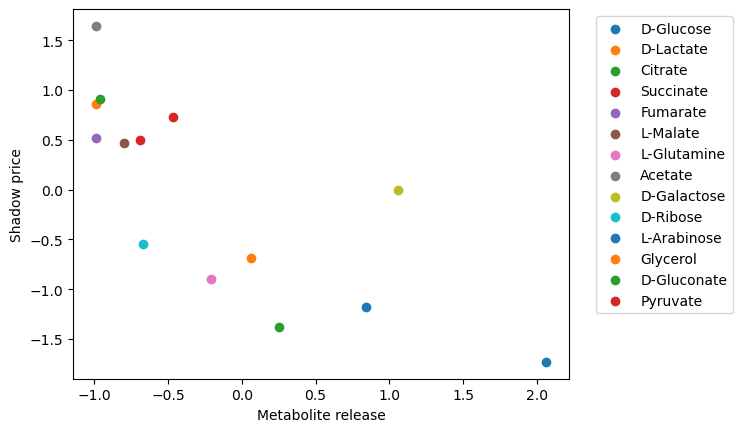

Inosinic acid
-0.7673568986144622 0.0013573468886392479 -0.8410677998713362 0.00016370711028037302
imp_c 0.0725 0.0319


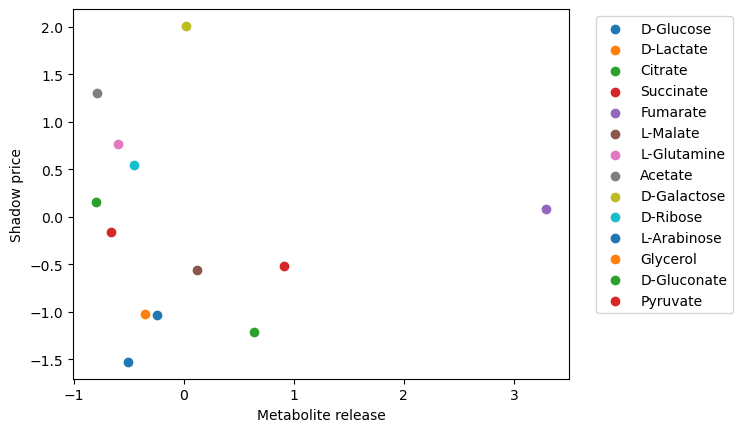

Lactic acid/Glyceraldehyde
-0.09341789591747222 0.7614719150061727 -0.3131868131868132 0.2974384220710292
lac__L_c 0.5835 0.3466


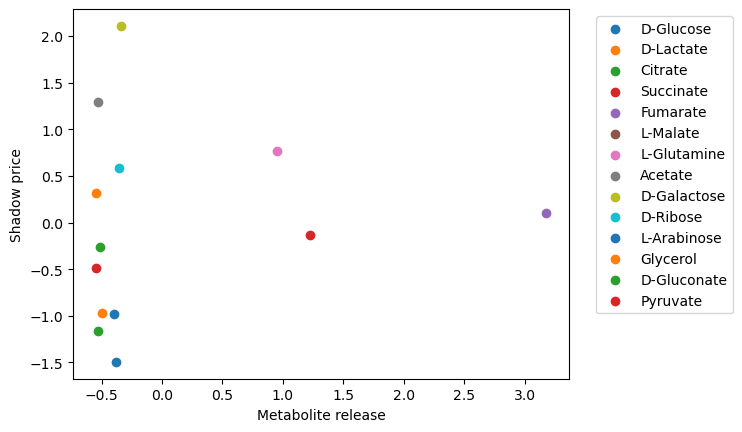

Malic acid
0.11581374893601487 0.7063449609906579 0.2200827391522918 0.46998875742238644
mal__D_c 0.6228 0.39


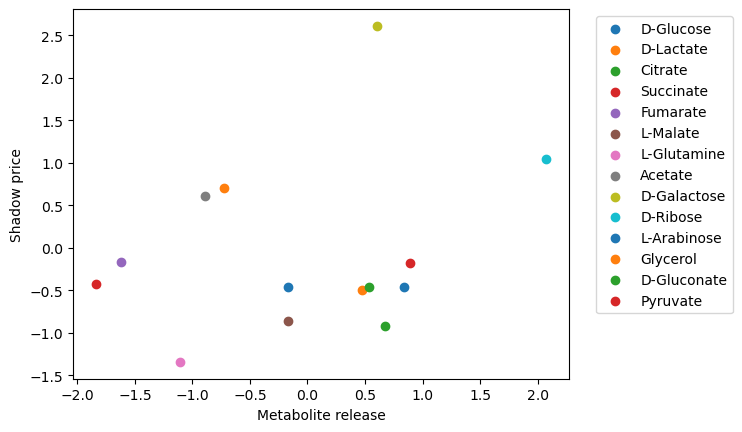

N-Methyl-L-glutamic acid
0.26190074660753465 0.36572333317029887 0.09010989010989012 0.7593388378159541
acglu_c 0.2316 0.0935


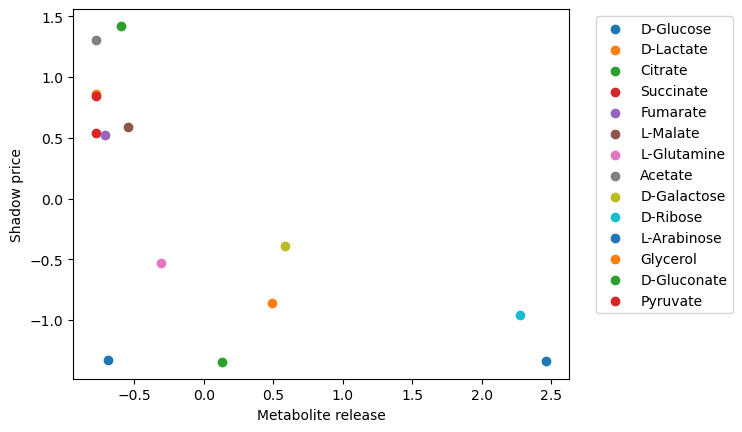

NAD
-0.6482901273874319 0.012155123366054536 -0.693376135650461 0.005961112964377703
nad_c 0.066 0.0289


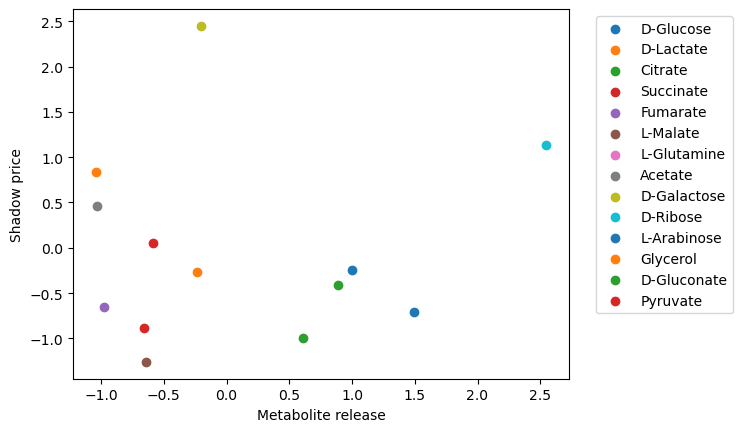

Orotic acid
0.06117665112405518 0.8426271144078209 0.016483516483516484 0.9573761750901849
orot_c 0.2628 0.1072


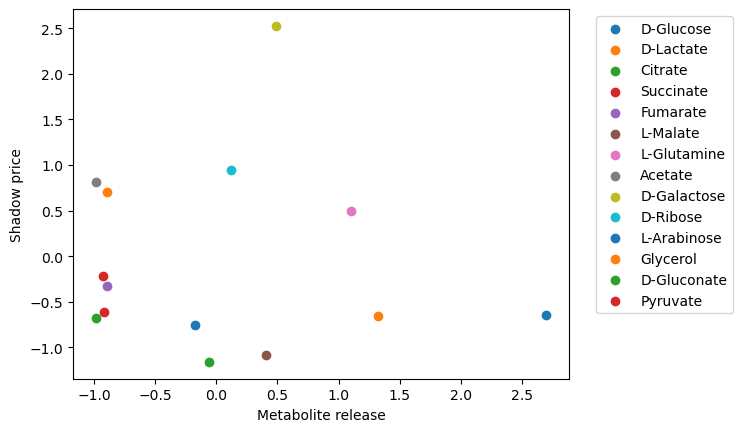

Oxoglutaric acid
-0.042591747268649505 0.8850506440748089 -0.059405976541875294 0.8401280416361696
akg_c 0.3919 0.1595


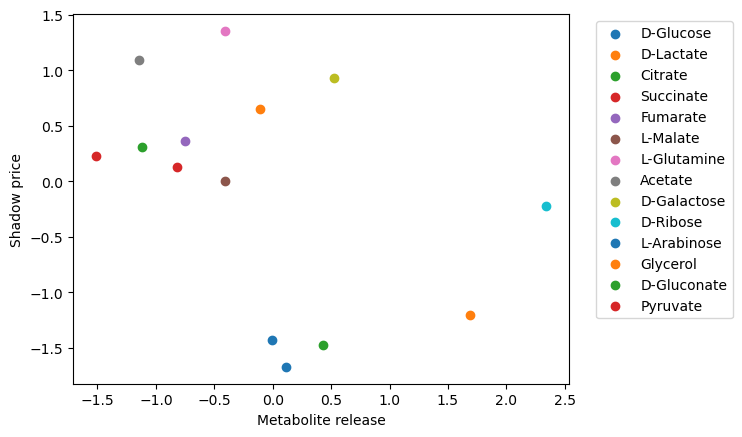

Phenylpyruvic acid
-0.41971837301478826 0.13516459916214912 -0.4461538461538462 0.10980712780122508
phpyr_c 0.301 0.151


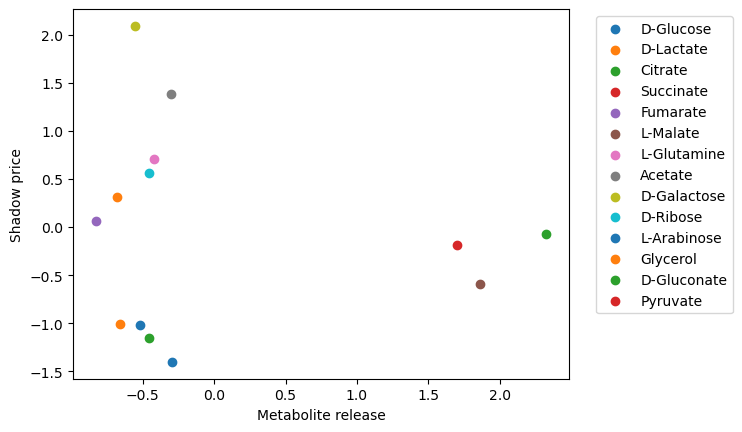

Pyruvic acid
-0.13326629328048883 0.6642680431321362 -0.19230769230769232 0.5290679872349875
pyr_c 0.6339 0.3618


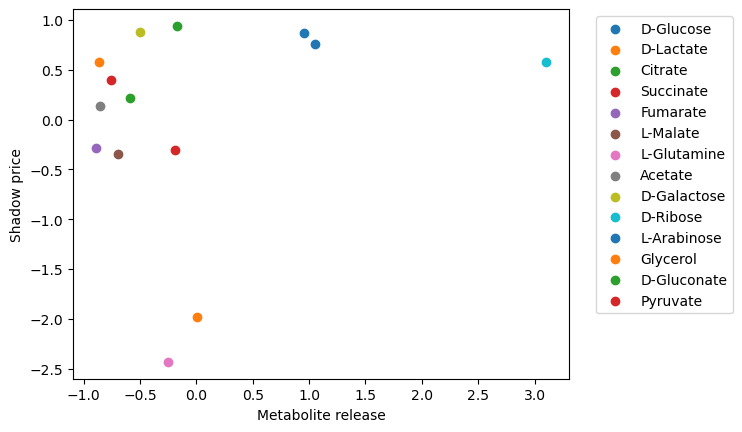

Uracil
0.1979096077016317 0.4976277547458855 0.2923076923076923 0.31052632038588196
ura_c 0.1833 0.095


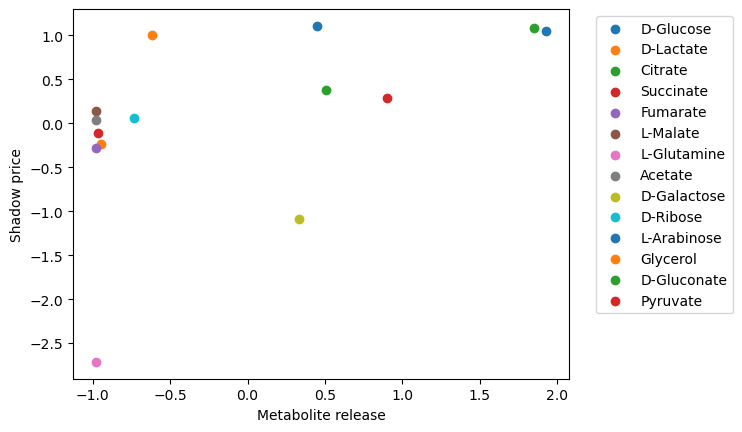

Xanthine
0.5015321226845814 0.0676758098303144 0.665934065934066 0.009322999096841759
xan_c 0.1063 0.0502


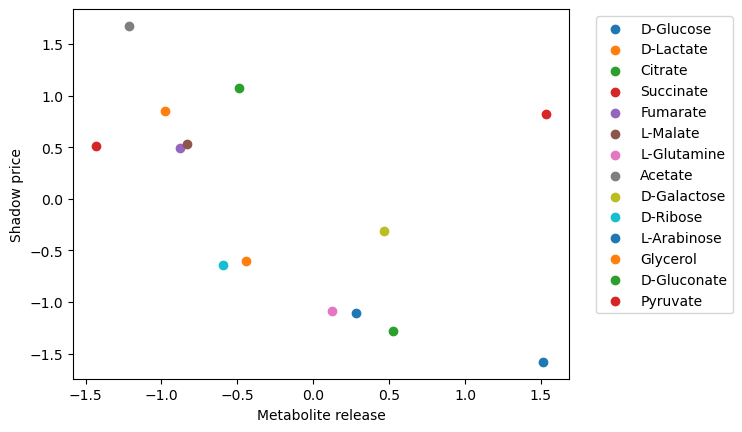

Xanthosine
-0.5494361078755238 0.04183350426488062 -0.5692307692307692 0.03361941707727023
xtsn_c 0.0719 0.0315


In [588]:
pcorrelations = []
scorrelations = []
ppvals = []
spvals = []
all_x = []
all_y = []

for m_id, m_name in zip(measured_mets, measured_metnames):
    x_arr = []
    y_arr = []
    for cs in carbon_sources:
        # if cs == 'D-Galactose':
        #     continue
        x = res_dict[cs][m_name]
        y = sp_dict[cs][m_id]
        if np.isfinite(x) and np.isfinite(y):
            x_arr.append(x)
            y_arr.append(y)
        all_x += x_arr
        all_y += y_arr
        plt.scatter(x,y, label = cs)
    plt.xlabel('Metabolite release')
    plt.ylabel('Shadow price')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.show()
    print(m_name)
    if len(x_arr)>4:
        prho, ppval = st.pearsonr(x_arr, y_arr)
        srho, spval = st.spearmanr(x_arr, y_arr)
        print(prho, ppval,srho, spval)
        print(m_id, np.round(rel_std[m_id], 4), np.round(std_log[m_id], 4))
        scorrelations.append(srho)
        pcorrelations.append(prho)
        spvals.append(spval)
        ppvals.append(ppval)

SignificanceResult(statistic=-0.16307597527555026, pvalue=2.6770202762102674e-20)

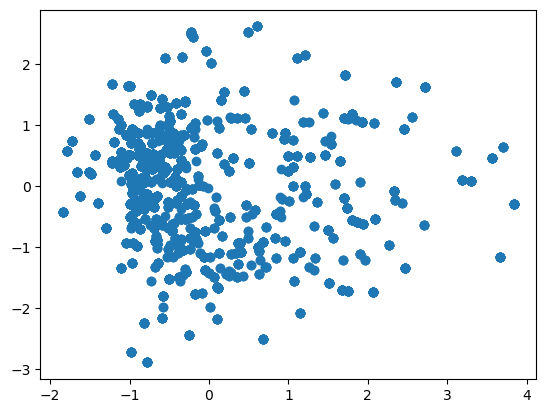

In [589]:
plt.scatter(all_x, all_y)
st.pearsonr(all_x, all_y)
st.spearmanr(all_x, all_y)

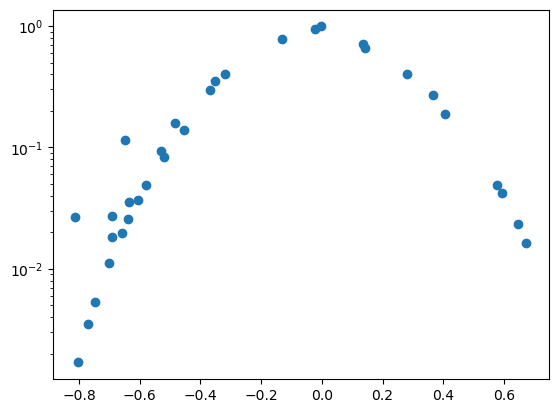

In [444]:
plt.scatter(pcorrelations, ppvals)
plt.yscale('log')

In [445]:
np.median(pcorrelations)

-0.46788856522819144

In [446]:
np.median(scorrelations)

-0.37948717948717947

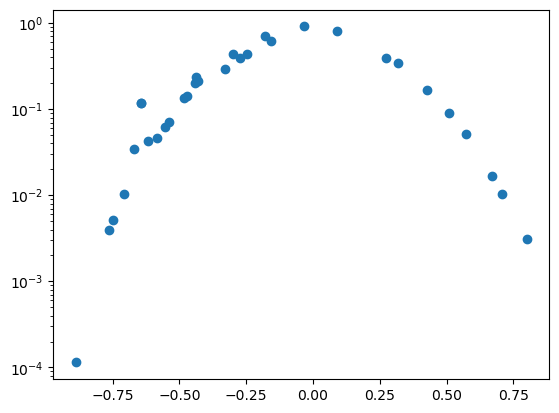

In [447]:
plt.scatter(scorrelations, spvals)
plt.yscale('log')

D-Glucose D-Lactate


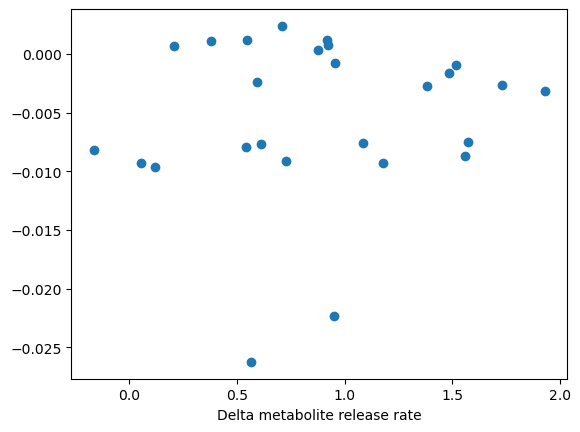

D-Glucose Citrate


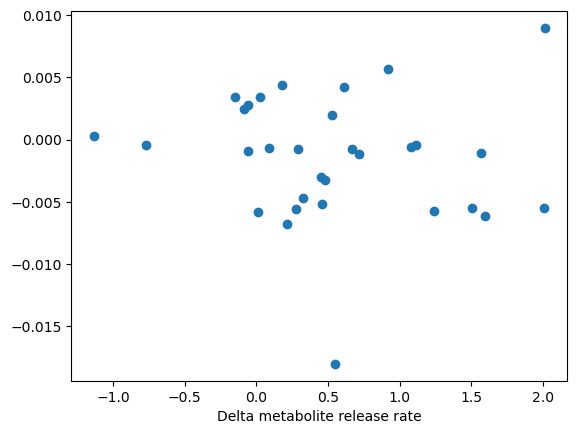

D-Glucose Succinate


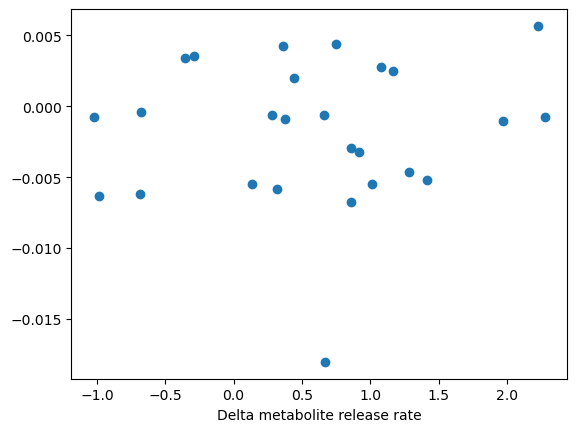

D-Glucose Fumarate


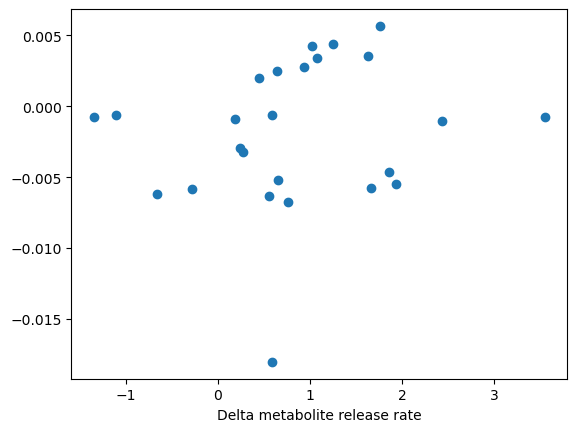

D-Glucose L-Malate


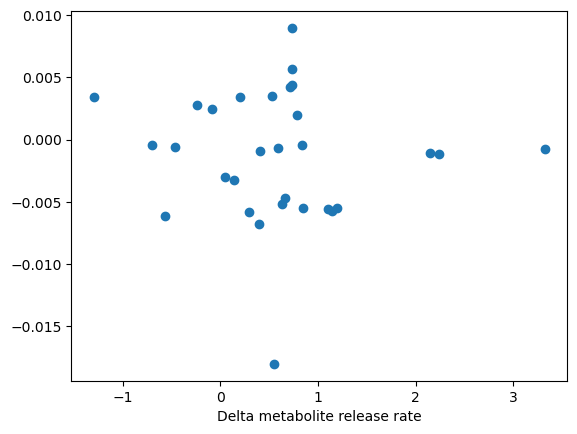

D-Glucose L-Glutamine


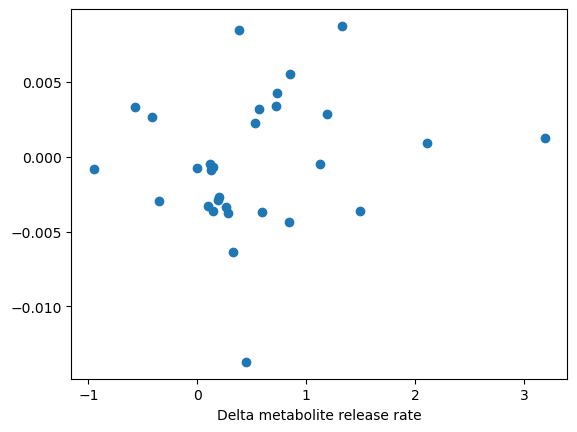

D-Glucose Acetate


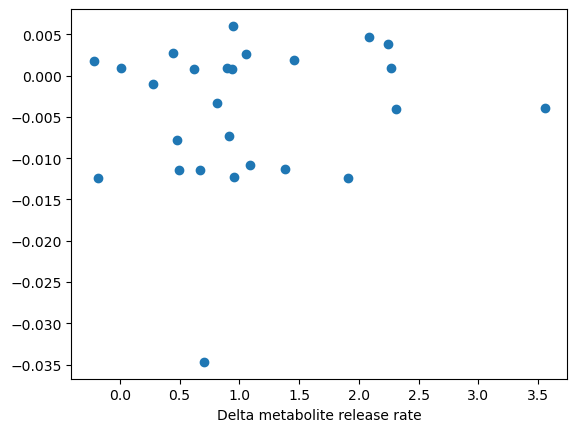

D-Glucose D-Galactose


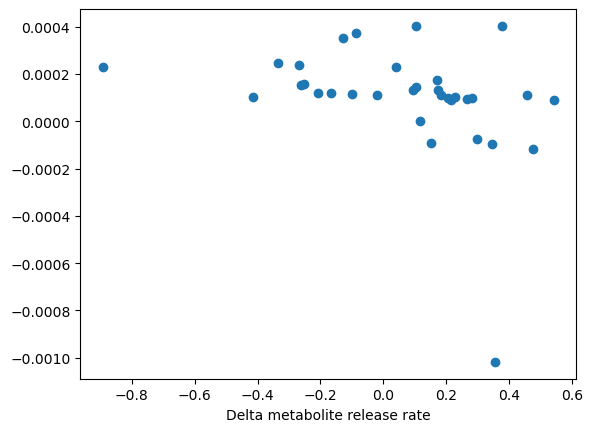

D-Glucose D-Ribose


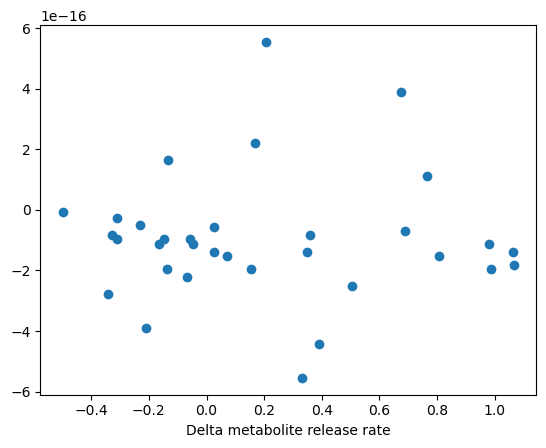

D-Glucose L-Arabinose


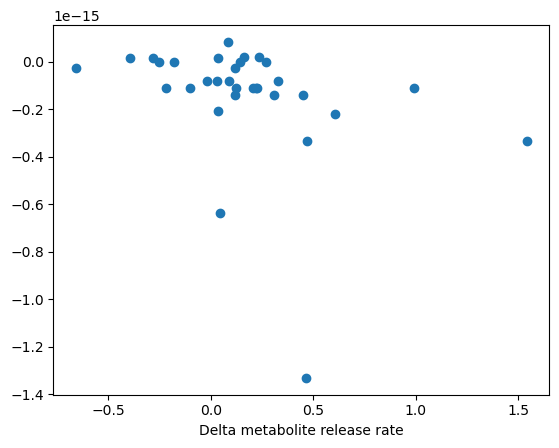

D-Glucose Glycerol


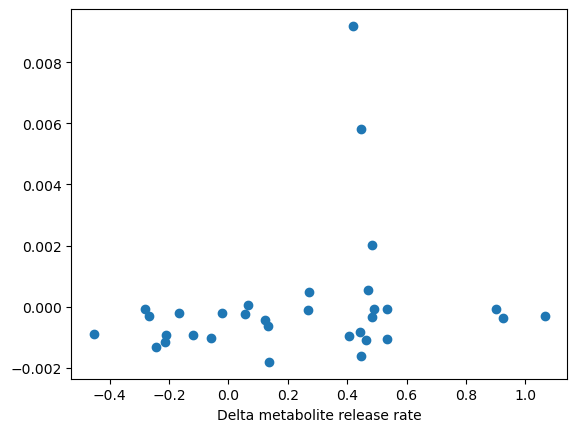

D-Glucose D-Gluconate


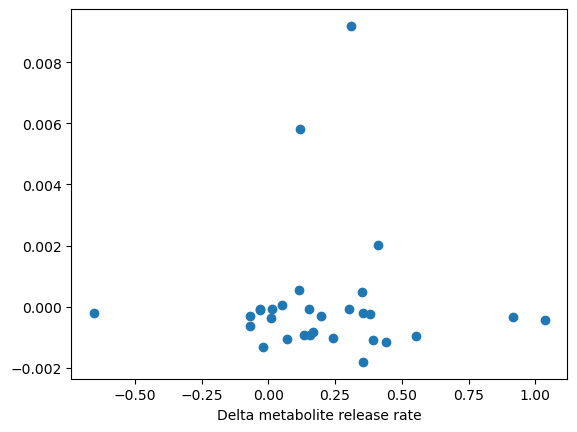

D-Glucose Pyruvate


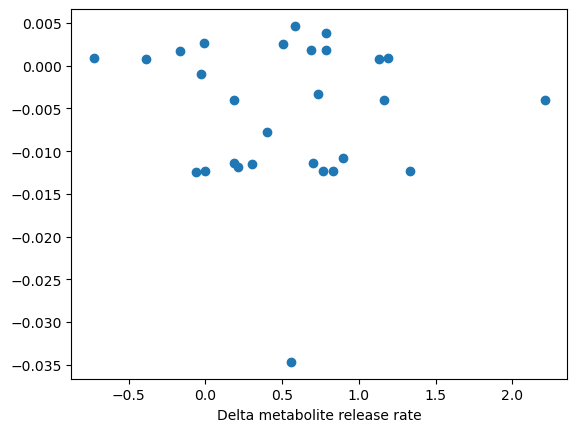

D-Lactate Citrate


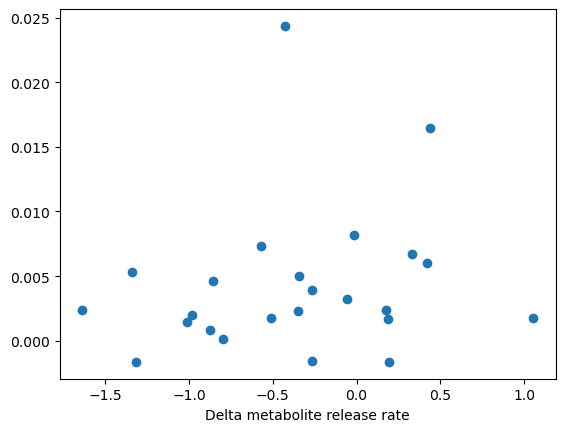

D-Lactate Succinate


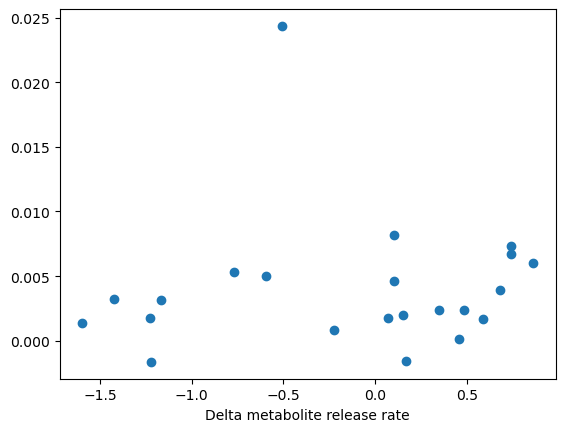

D-Lactate Fumarate


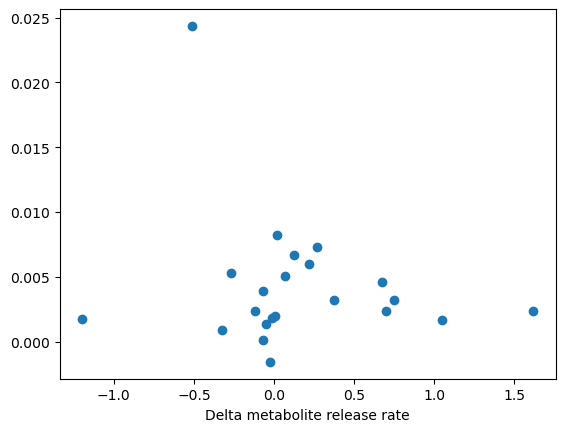

D-Lactate L-Malate


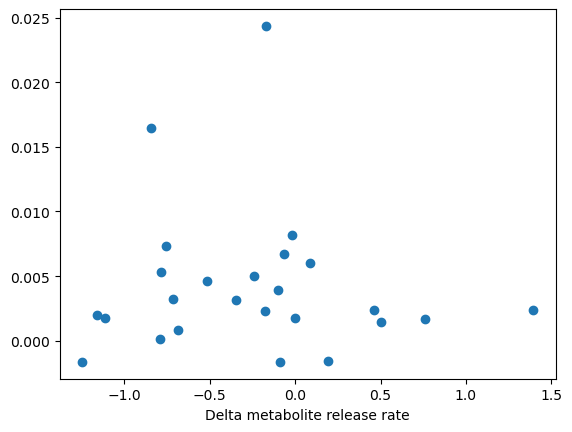

D-Lactate L-Glutamine


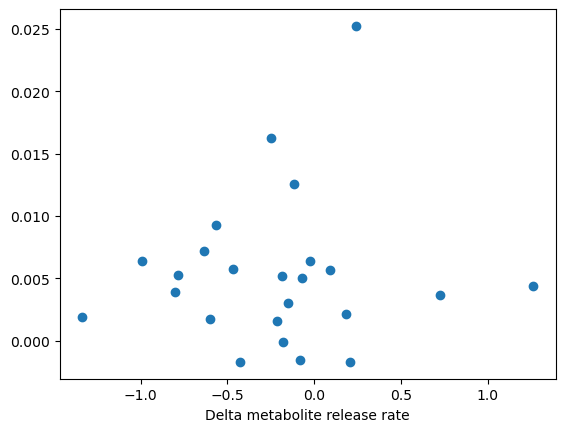

D-Lactate Acetate


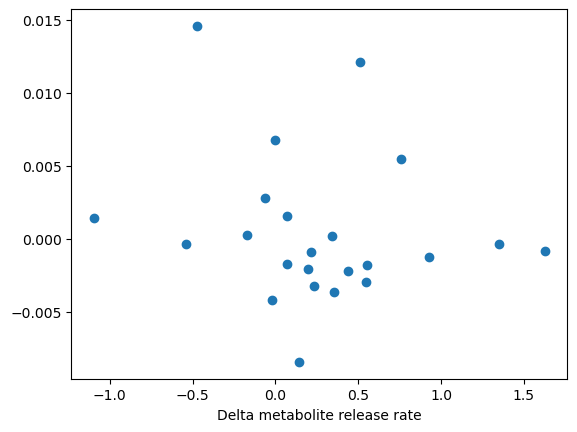

D-Lactate D-Galactose


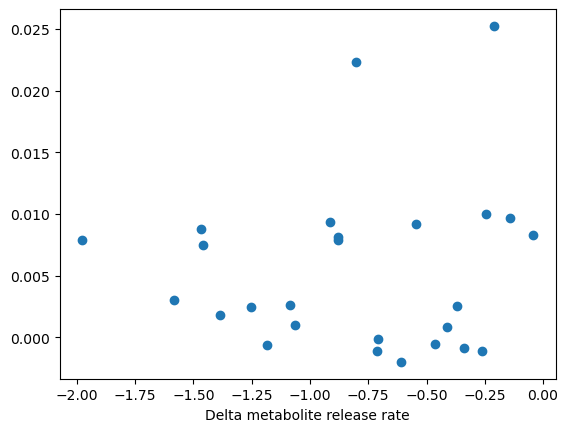

D-Lactate D-Ribose


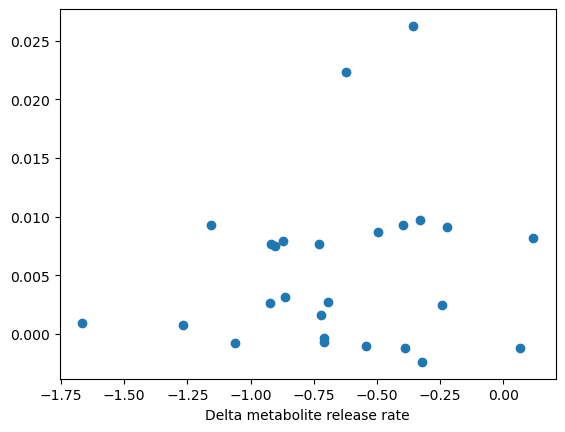

D-Lactate L-Arabinose


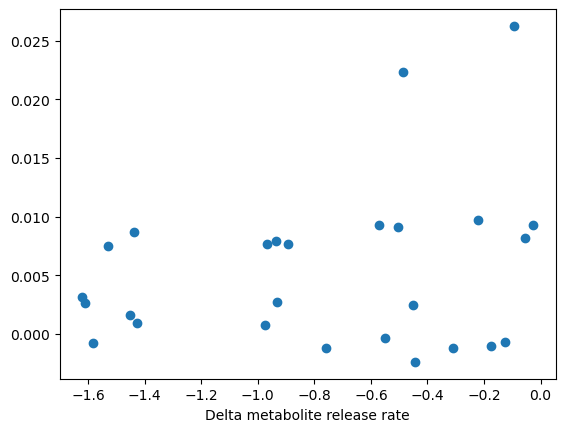

D-Lactate Glycerol


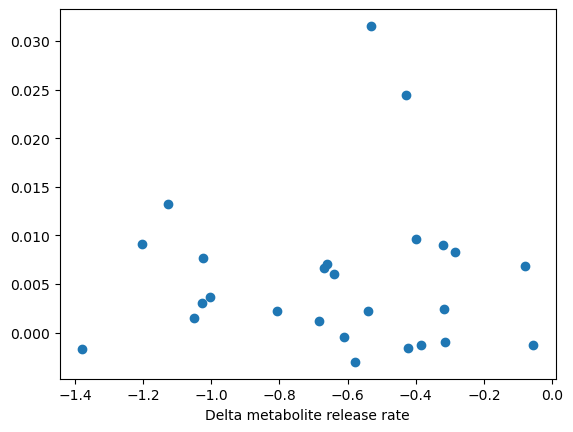

D-Lactate D-Gluconate


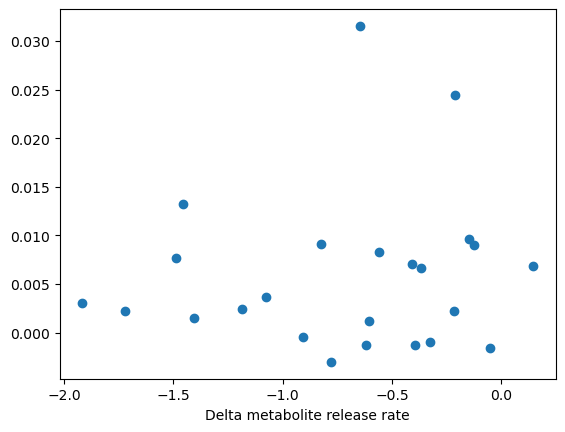

D-Lactate Pyruvate


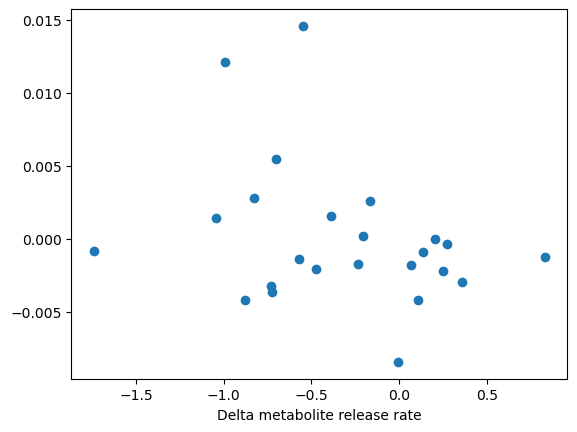

Citrate Succinate


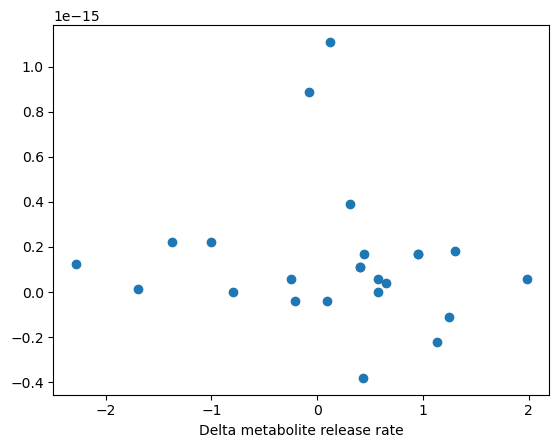

Citrate Fumarate


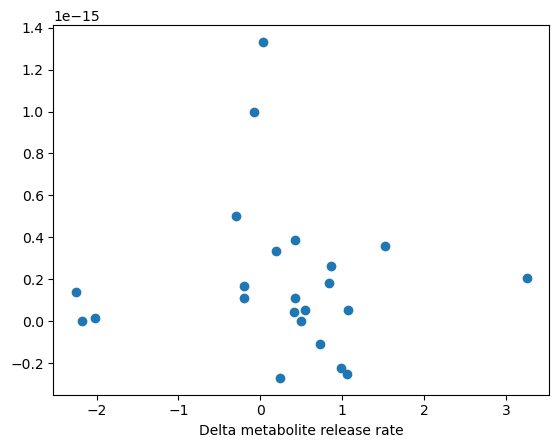

Citrate L-Malate


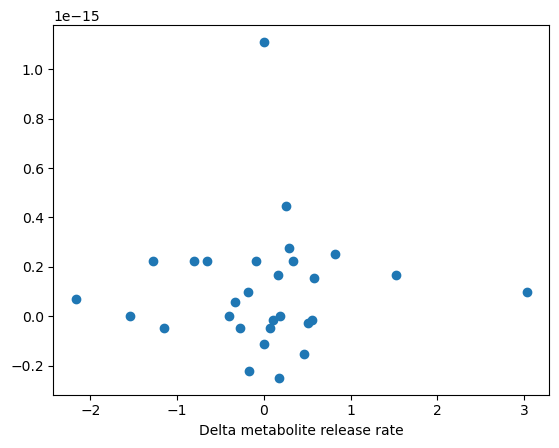

Citrate L-Glutamine


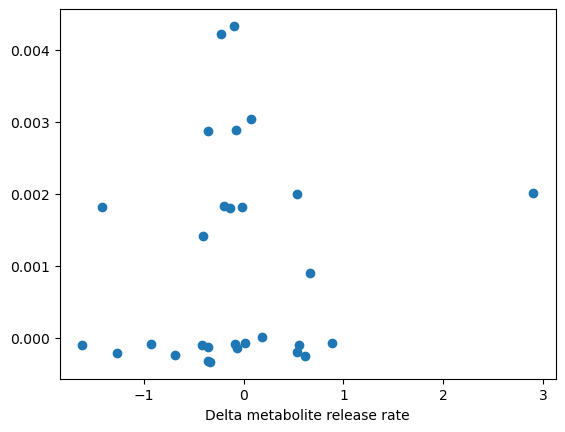

Citrate Acetate


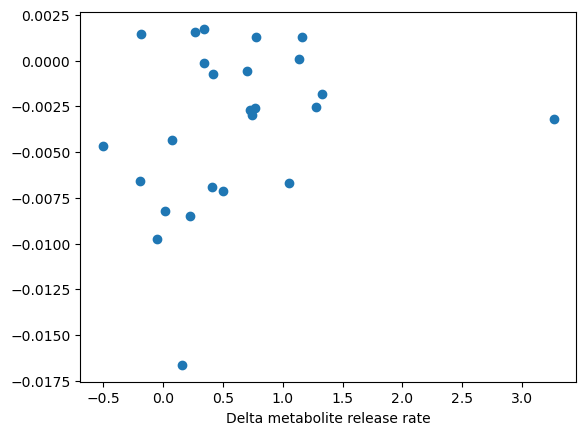

Citrate D-Galactose


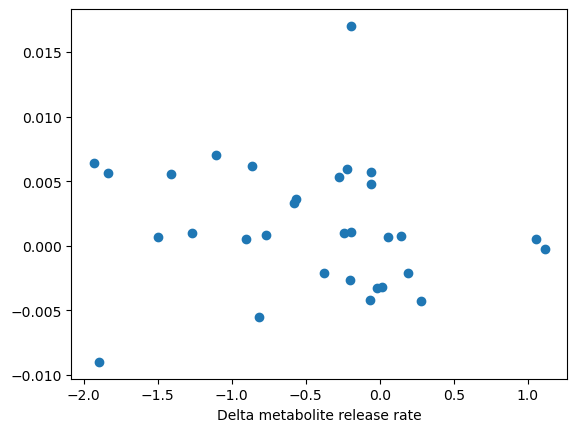

Citrate D-Ribose


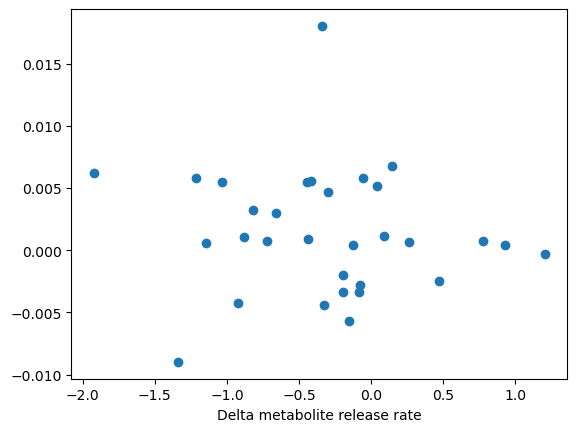

Citrate L-Arabinose


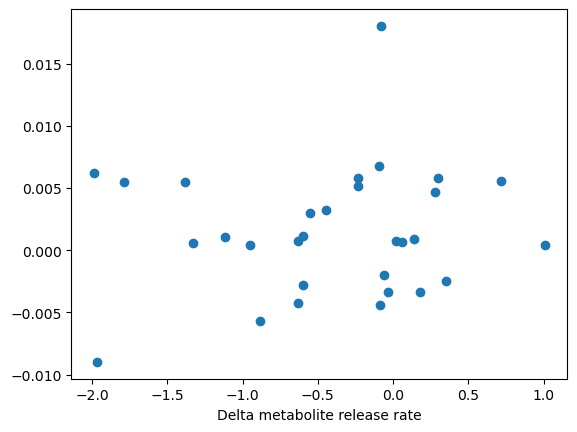

Citrate Glycerol


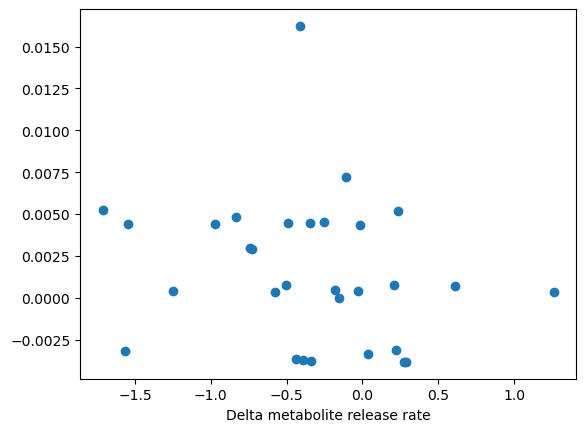

Citrate D-Gluconate


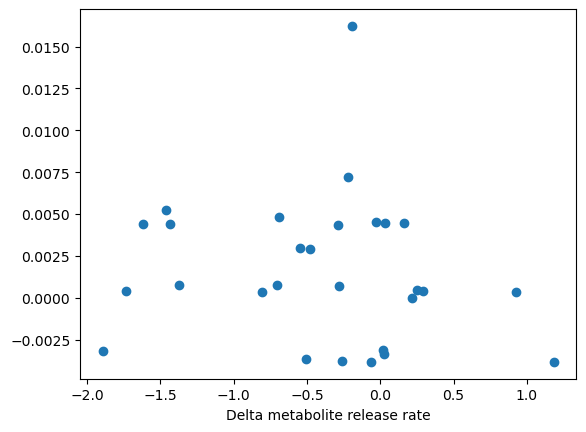

Citrate Pyruvate


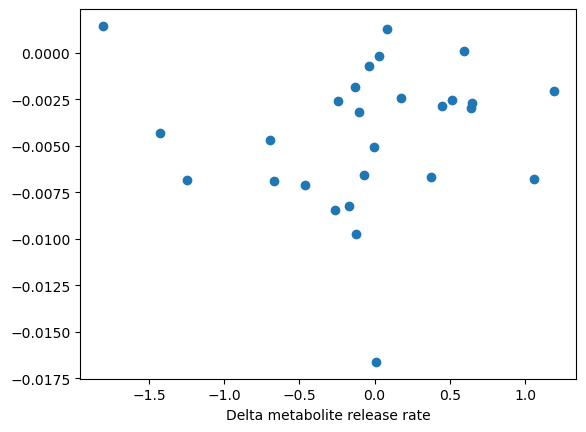

Succinate Fumarate


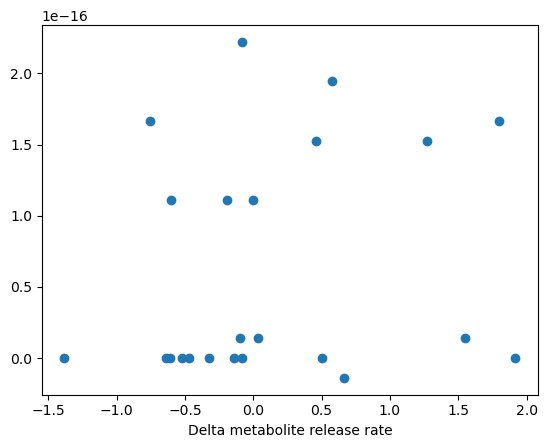

Succinate L-Malate


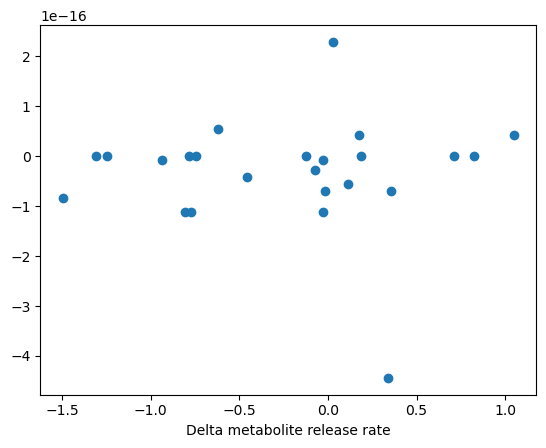

Succinate L-Glutamine


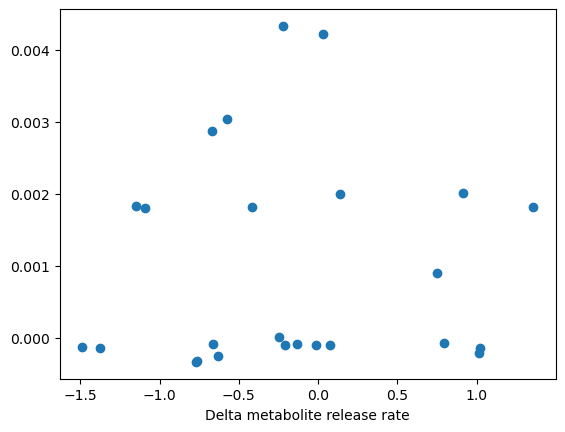

Succinate Acetate


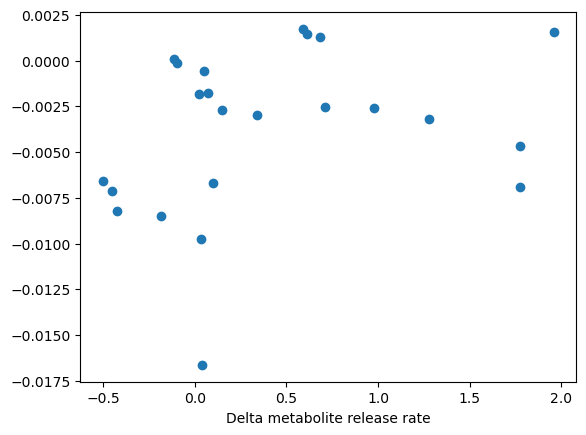

Succinate D-Galactose


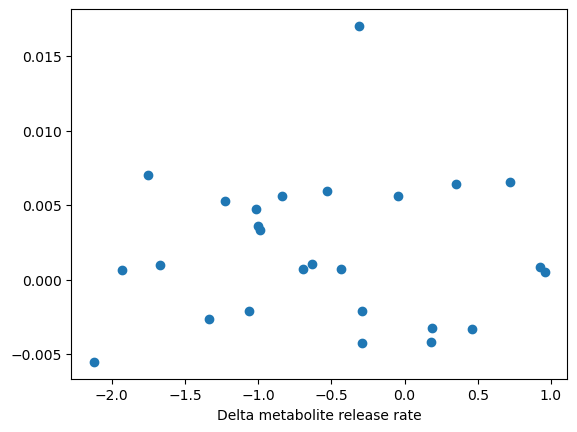

Succinate D-Ribose


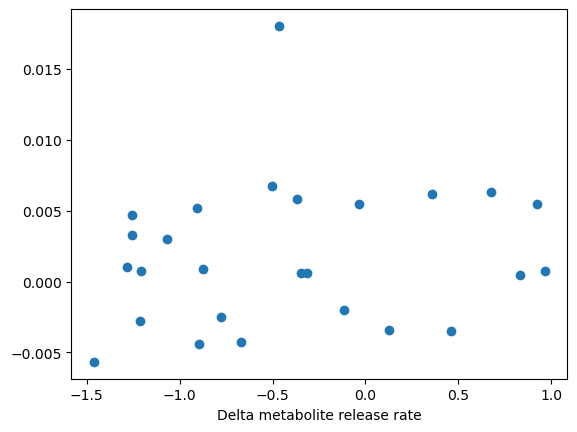

Succinate L-Arabinose


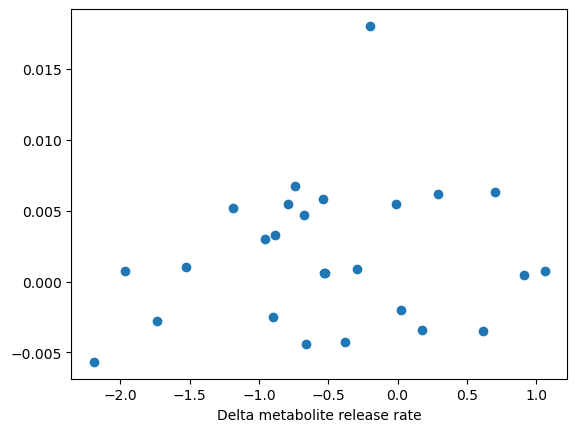

Succinate Glycerol


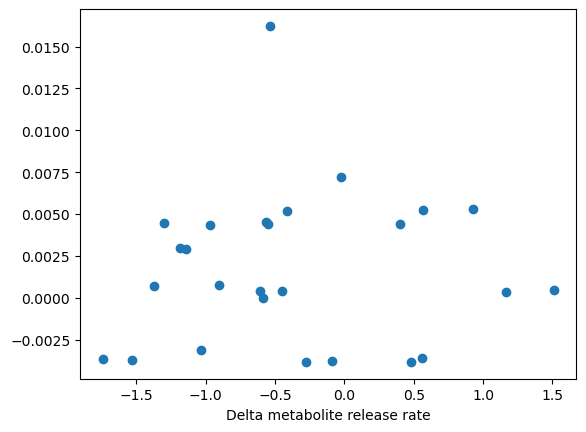

Succinate D-Gluconate


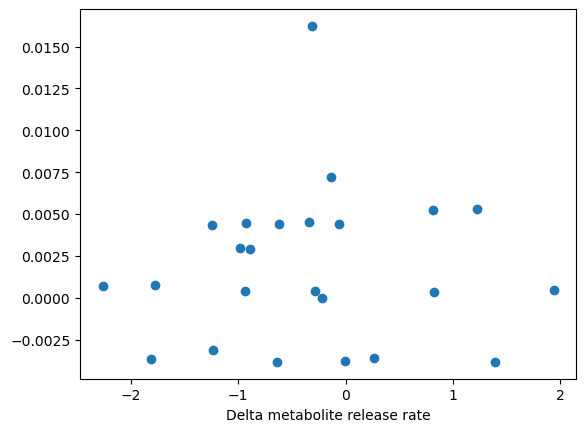

Succinate Pyruvate


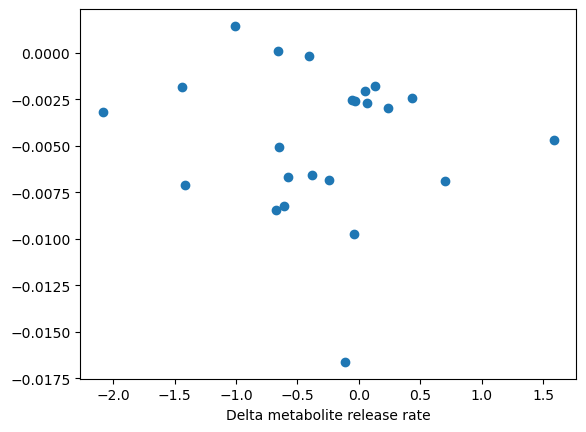

Fumarate L-Malate


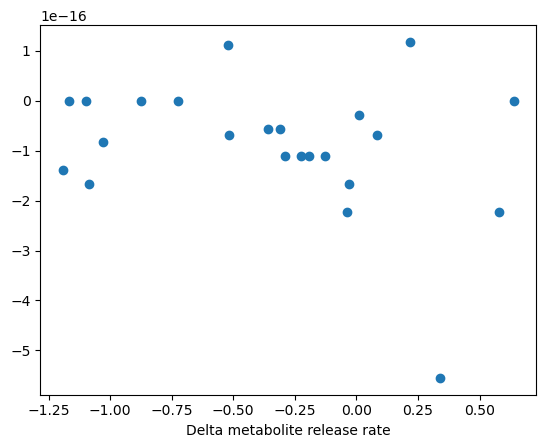

Fumarate L-Glutamine


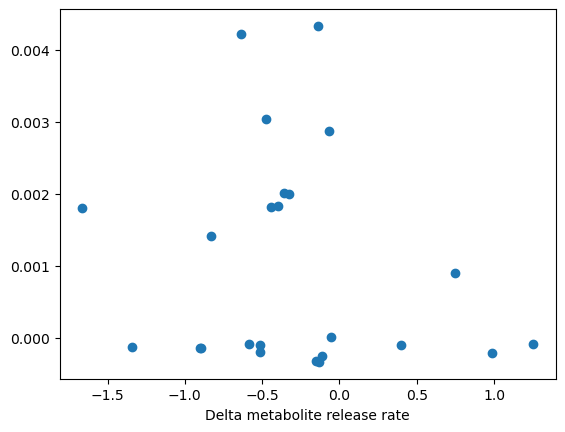

Fumarate Acetate


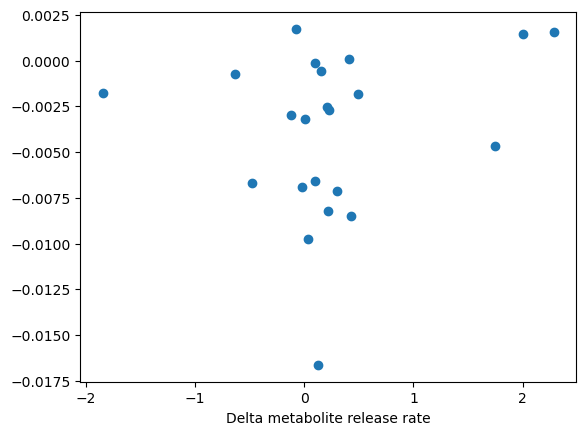

Fumarate D-Galactose


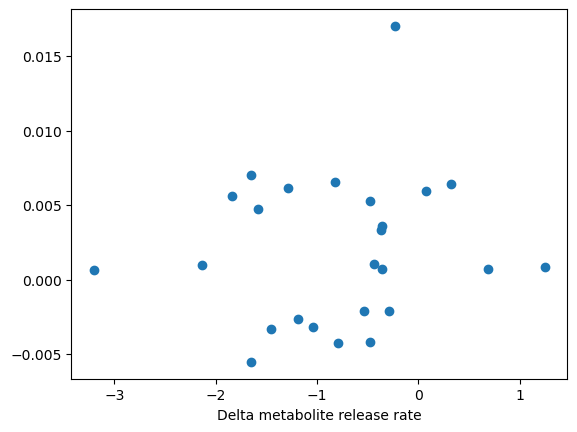

Fumarate D-Ribose


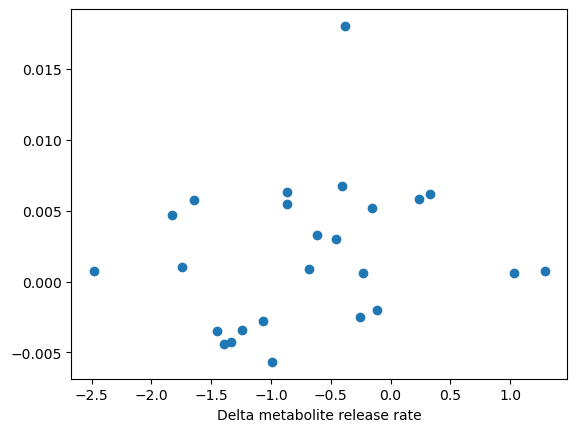

Fumarate L-Arabinose


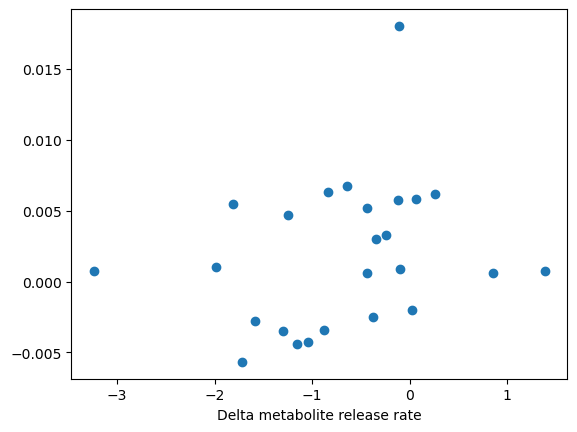

Fumarate Glycerol


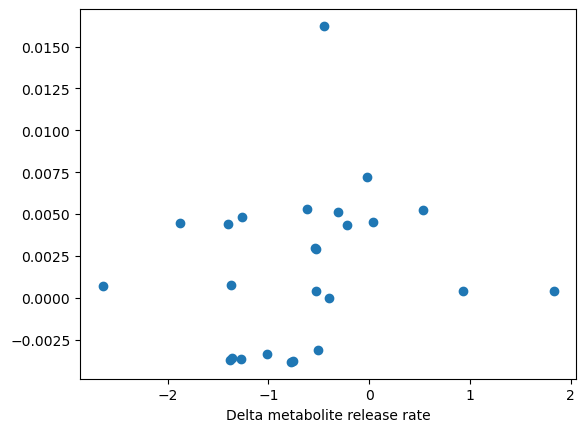

Fumarate D-Gluconate


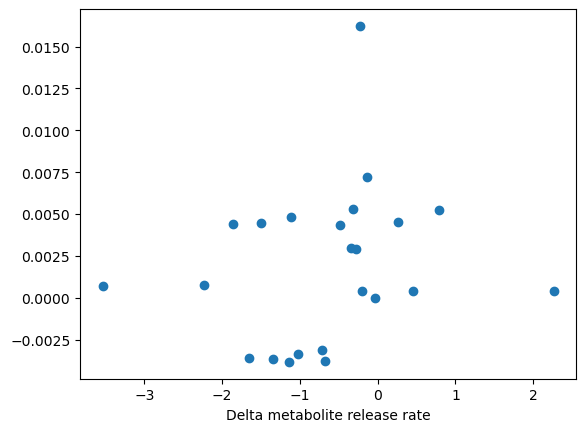

Fumarate Pyruvate


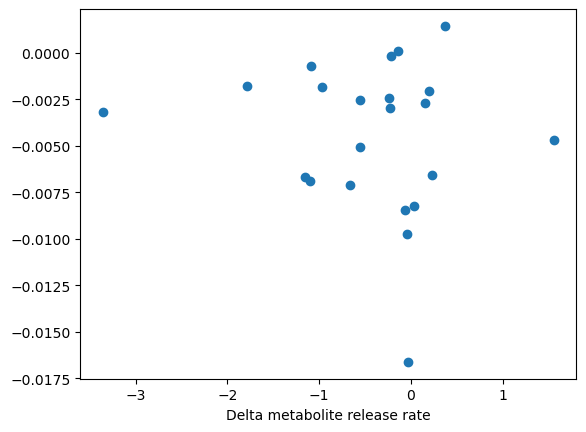

L-Malate L-Glutamine


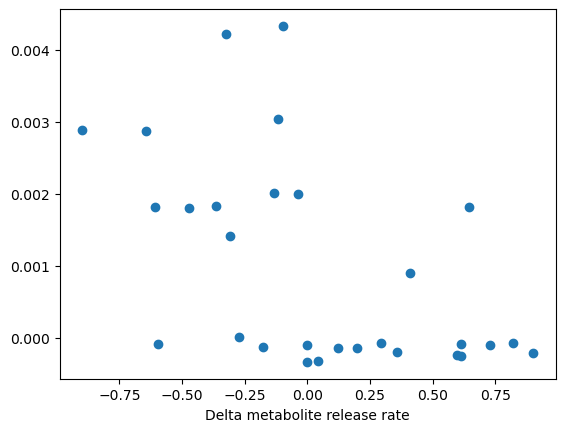

L-Malate Acetate


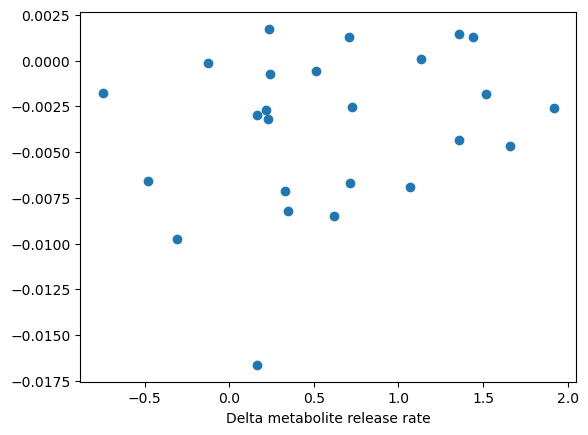

L-Malate D-Galactose


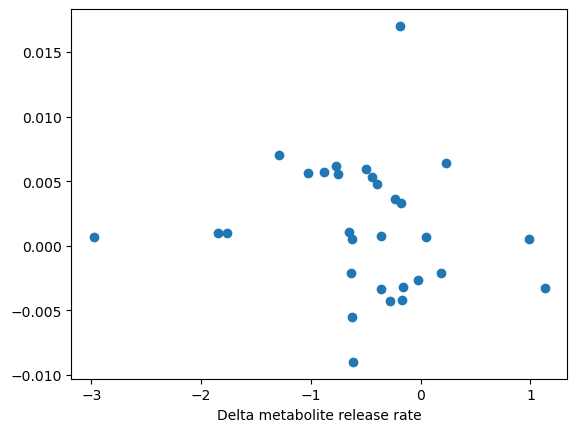

L-Malate D-Ribose


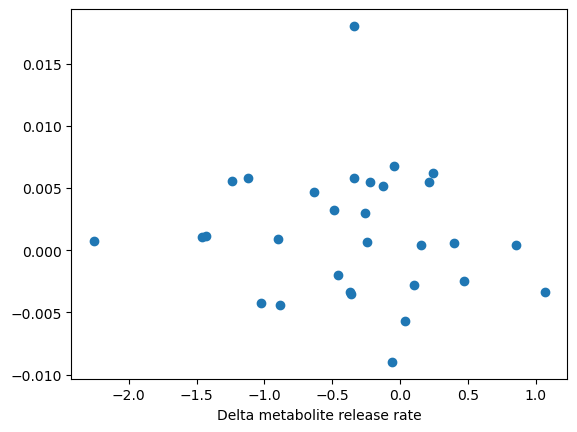

L-Malate L-Arabinose


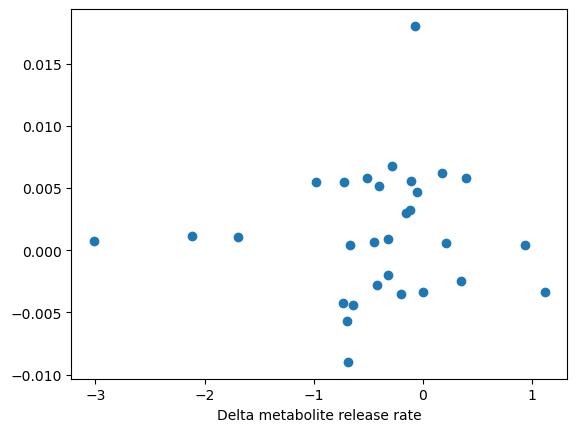

L-Malate Glycerol


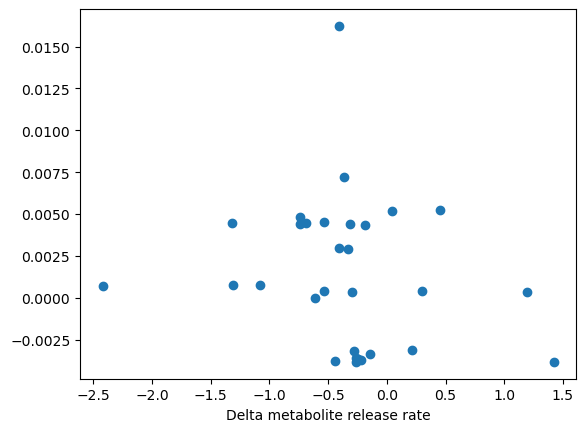

L-Malate D-Gluconate


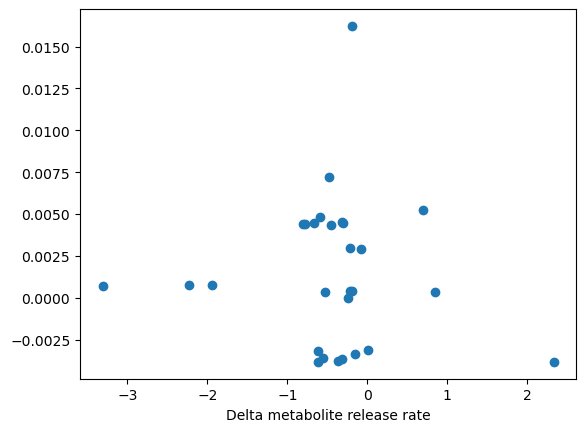

L-Malate Pyruvate


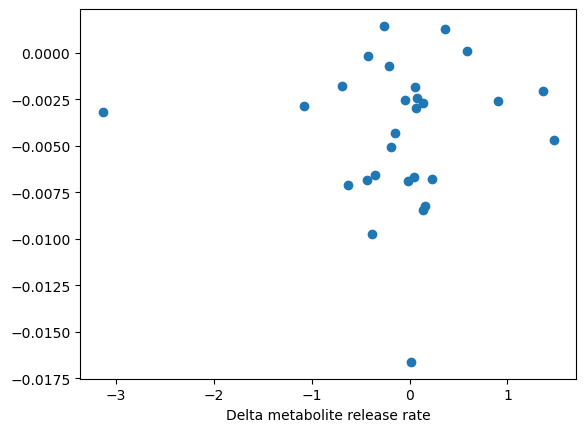

L-Glutamine Acetate


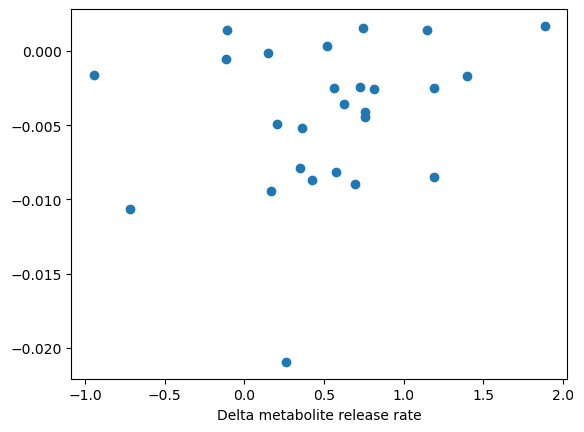

L-Glutamine D-Galactose


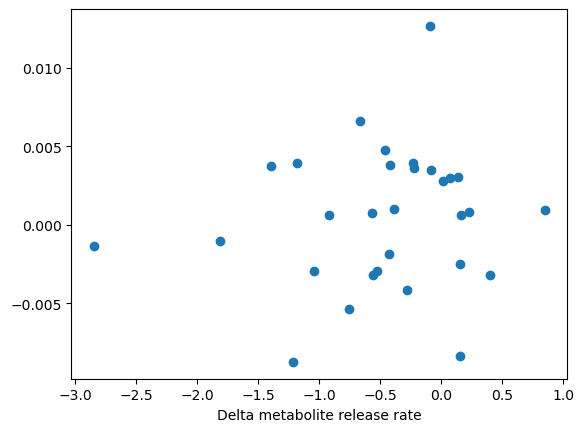

L-Glutamine D-Ribose


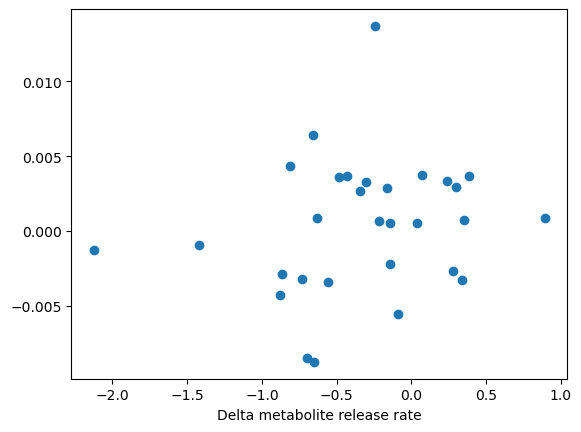

L-Glutamine L-Arabinose


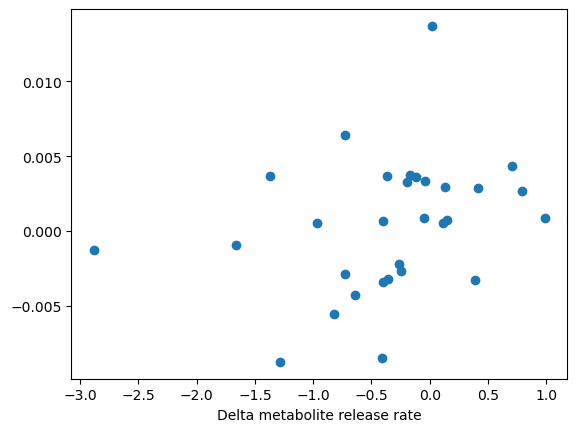

L-Glutamine Glycerol


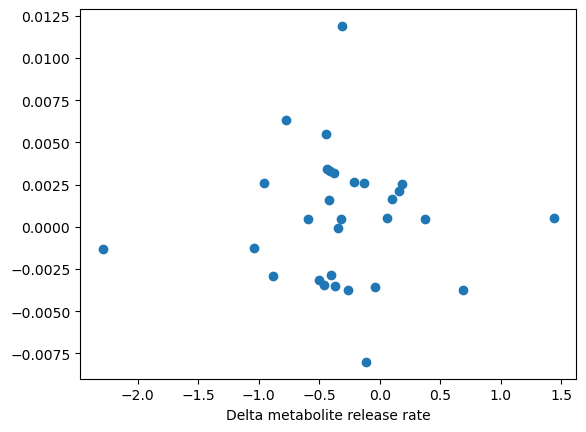

L-Glutamine D-Gluconate


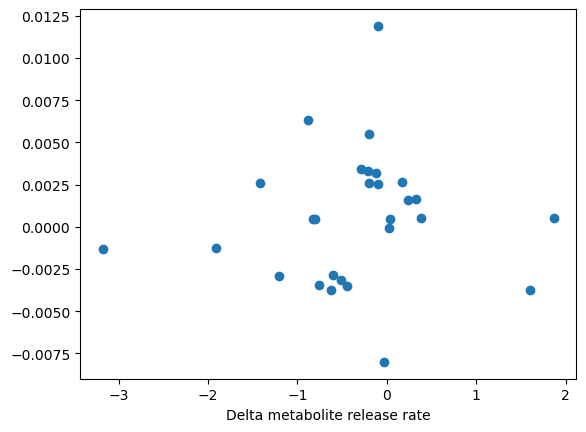

L-Glutamine Pyruvate


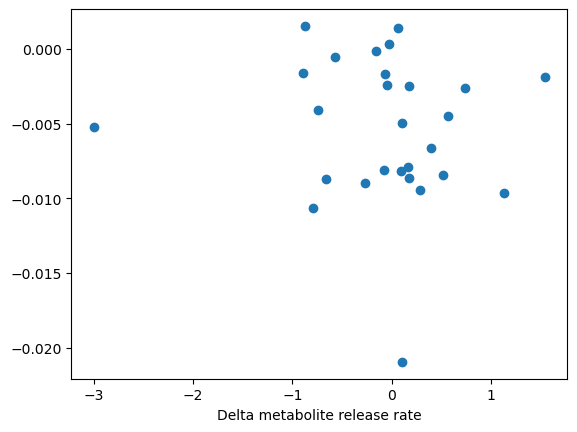

Acetate D-Galactose


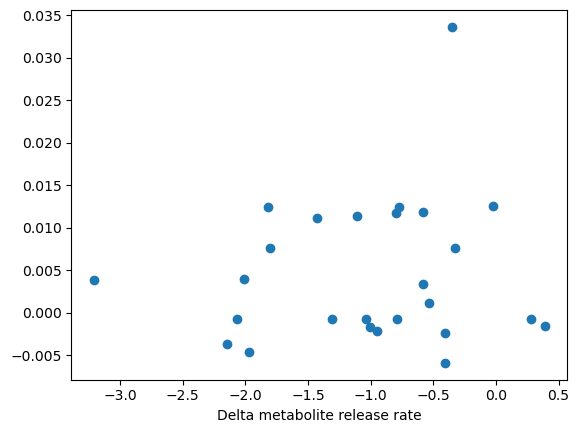

Acetate D-Ribose


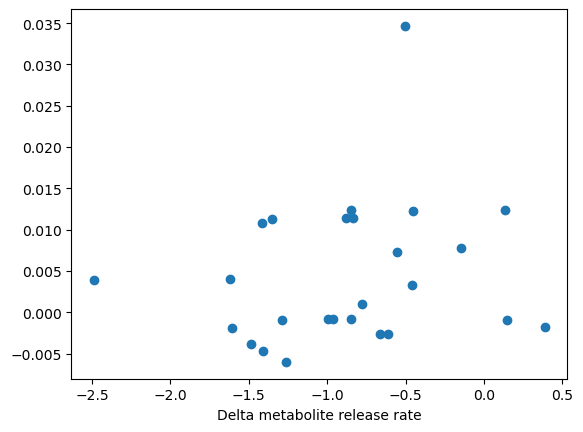

Acetate L-Arabinose


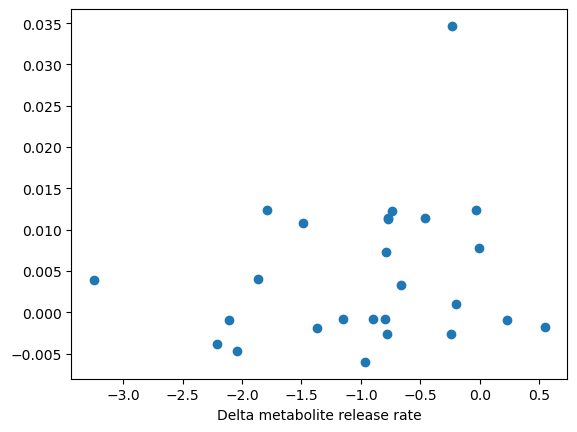

Acetate Glycerol


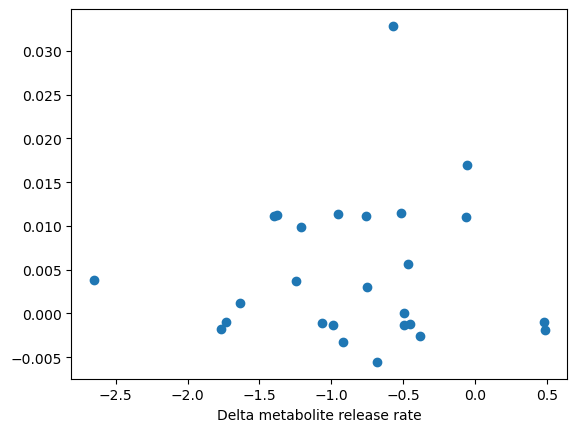

Acetate D-Gluconate


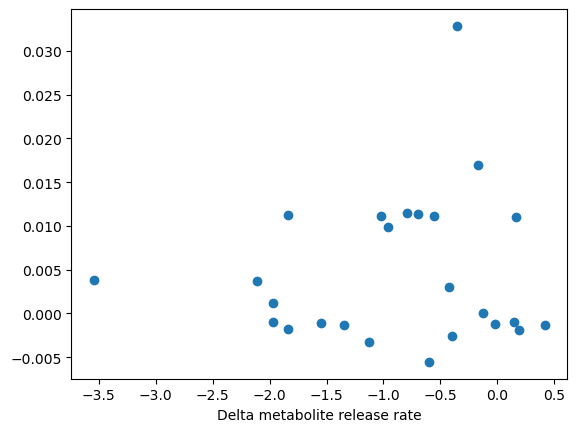

Acetate Pyruvate


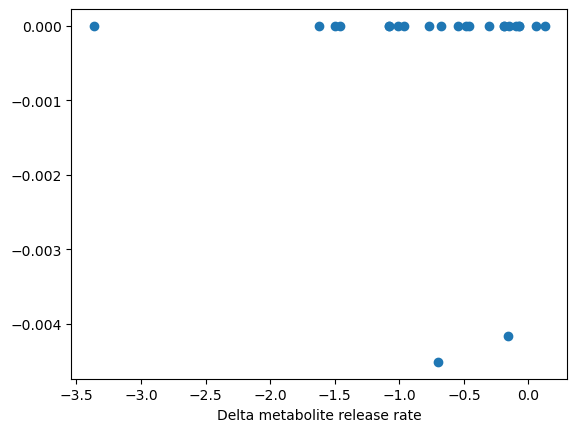

D-Galactose D-Ribose


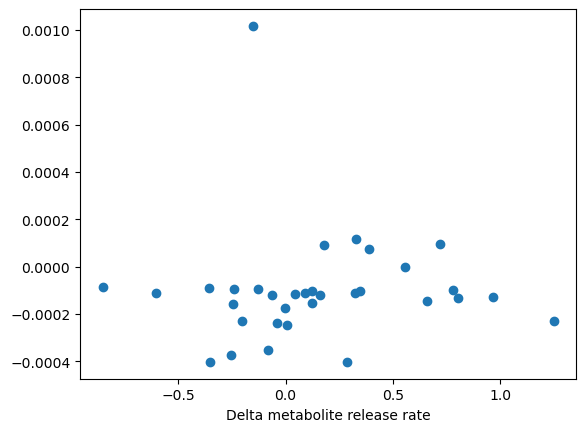

D-Galactose L-Arabinose


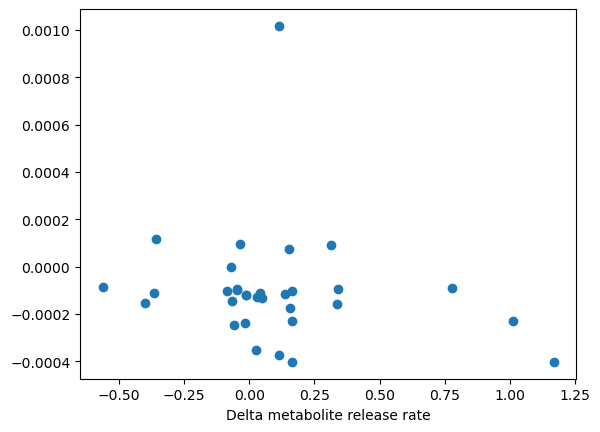

D-Galactose Glycerol


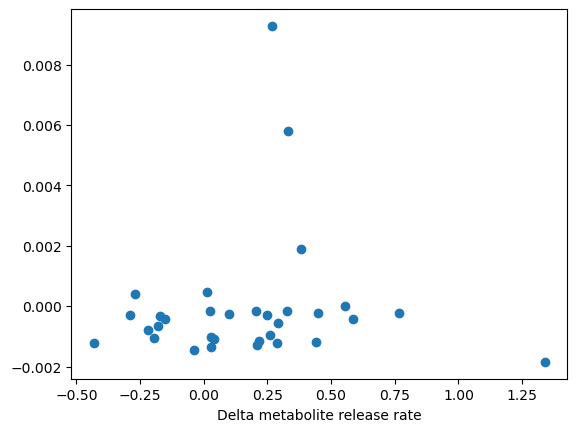

D-Galactose D-Gluconate


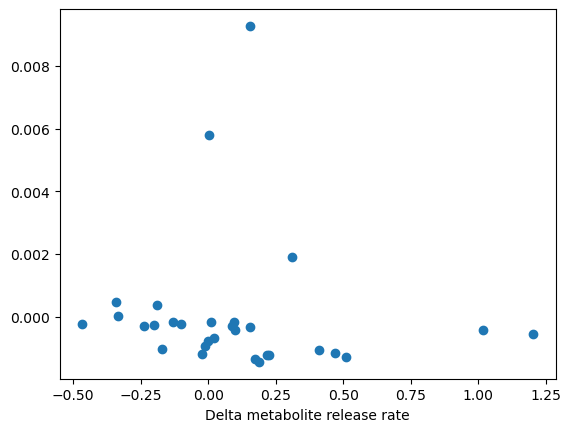

D-Galactose Pyruvate


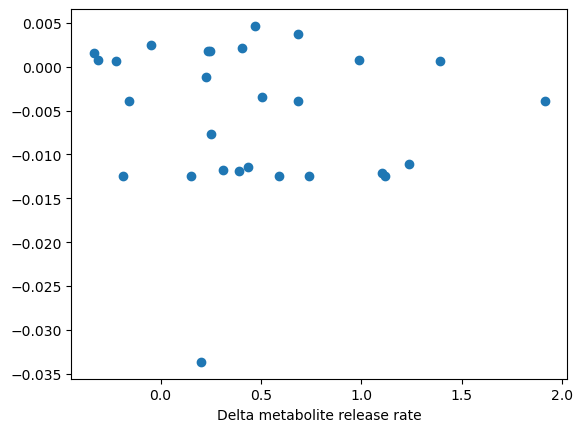

D-Ribose L-Arabinose


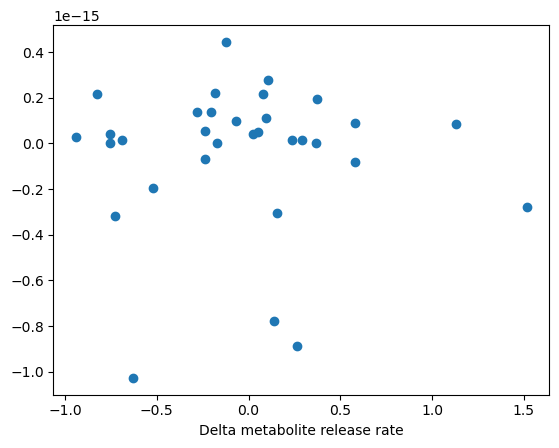

D-Ribose Glycerol


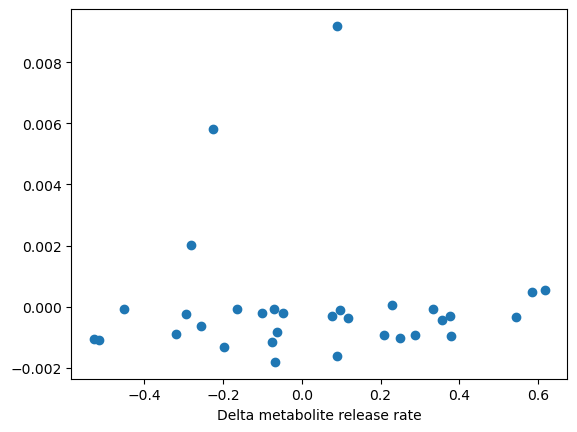

D-Ribose D-Gluconate


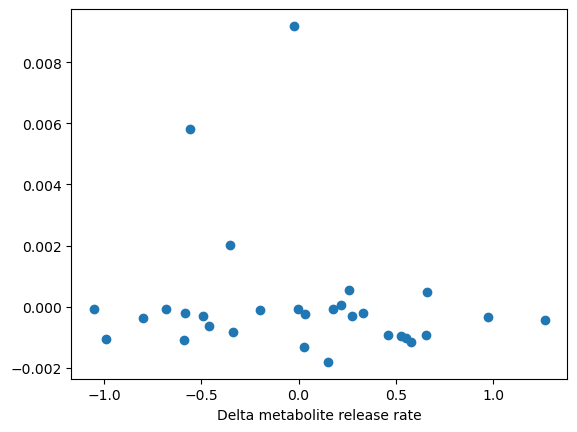

D-Ribose Pyruvate


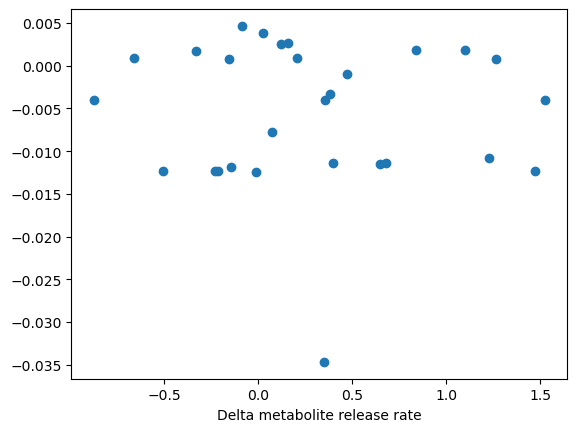

L-Arabinose Glycerol


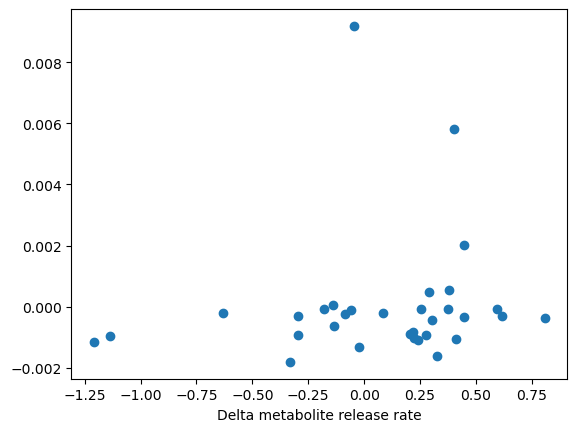

L-Arabinose D-Gluconate


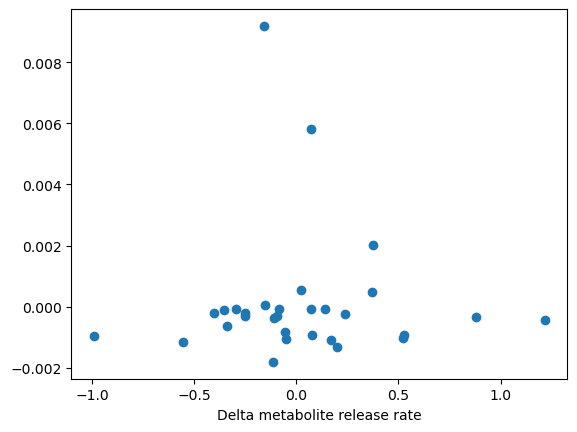

L-Arabinose Pyruvate


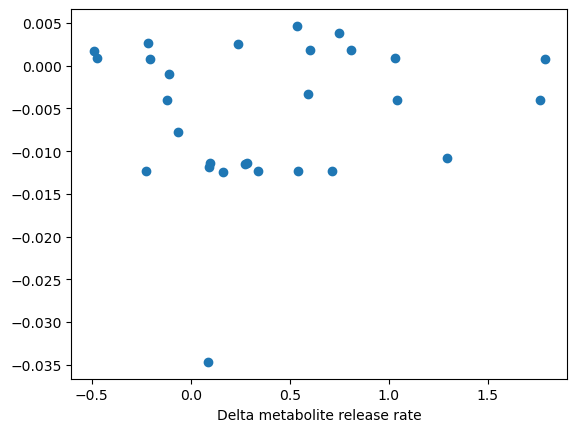

Glycerol D-Gluconate


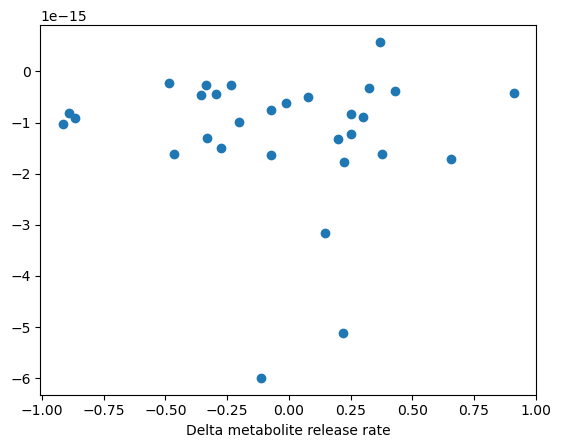

Glycerol Pyruvate


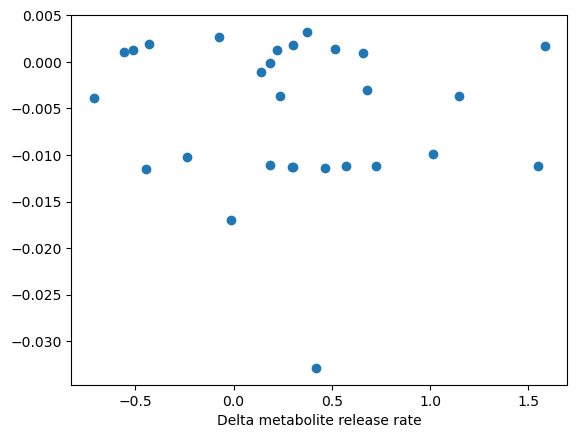

D-Gluconate Pyruvate


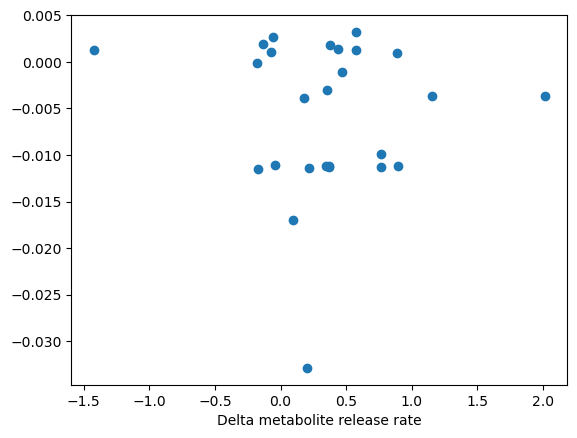

In [311]:
pcorrelations = []
scorrelations = []
ppvals = []
spvals = []
for i, cs1 in enumerate(carbon_sources):
    for j, cs2 in enumerate(carbon_sources):
        if j <= i:
              continue
            
        if cs1==cs2:
            continue
        x_arr = []
        y_arr = []
        print(cs1, cs2)
        for m_id, m_name in zip(measured_mets, measured_metnames):
            dx = res_dict[cs1][m_name] - res_dict[cs2][m_name]
            dy = sp_dict[cs1][m_id] - sp_dict[cs2][m_id]
            if np.isfinite(dx) and np.isfinite(dy):
                x_arr.append(dx)
                y_arr.append(dy)
        plt.scatter(x_arr, y_arr)
        plt.xlabel('Delta metabolite release rate')
        plt.ylabel(
        plt.show()
        prho, ppval = st.pearsonr(x_arr, y_arr)
        srho, spval = st.spearmanr(x_arr, y_arr)
        scorrelations.append(srho)
        pcorrelations.append(prho)
        spvals.append(spval)
        ppvals.append(ppval)
            

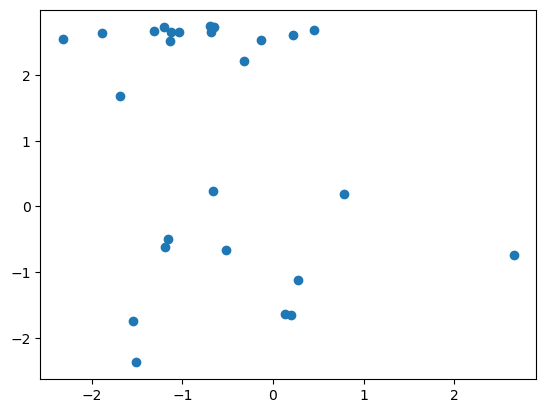

In [300]:
plt.scatter(x_arr, y_arr)

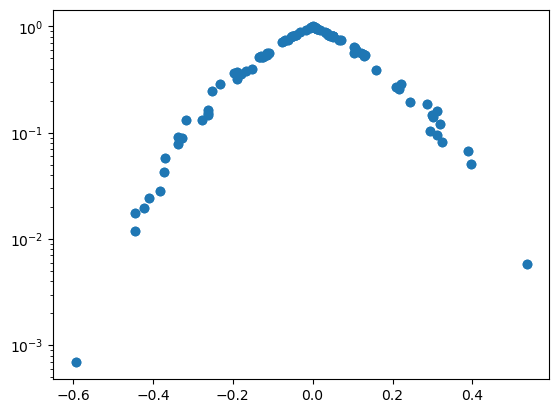

In [302]:
plt.scatter(scorrelations, spvals)
plt.yscale('log')

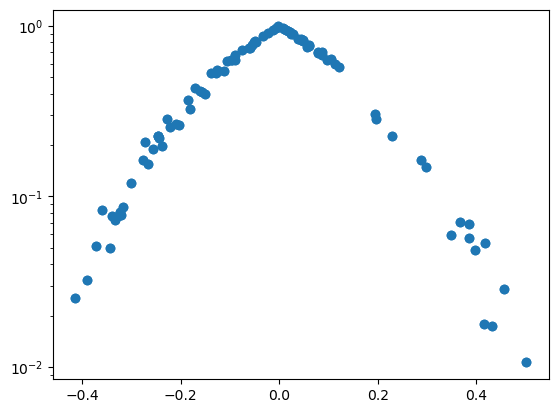

In [303]:
plt.scatter(pcorrelations, ppvals)
plt.yscale('log')

In [253]:
pval

0.3076020482722407

In [158]:
c1 = 'D-Glucose'
c2 = 'D-Lactate'
# tmp = (result.T[c1]/growth_dict[c1])-(result.T[c2]/growth_dict[c2])#/result.T['D-Glucose']
# tmp = (result.T[c1]*growth_dict[c1])-(result.T[c2]*growth_dict[c2])#/result.T['D-Glucose']


rel_diff = np.abs((dfsp[c1]-dfsp[c2])/dfsp[c1])
tmp = np.abs((result.T[c1])-(result.T[c2]))/result.T['D-Glucose']


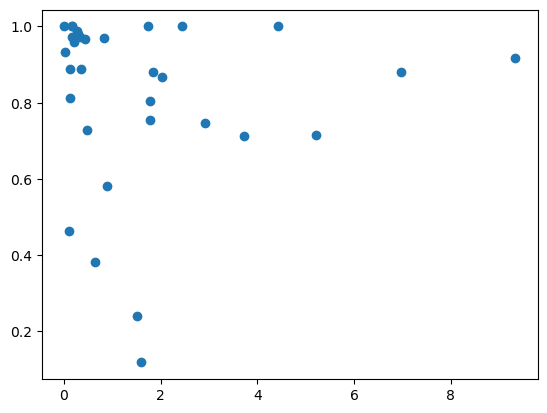

In [159]:
plt.scatter(rel_diff, tmp[measured_metnames])

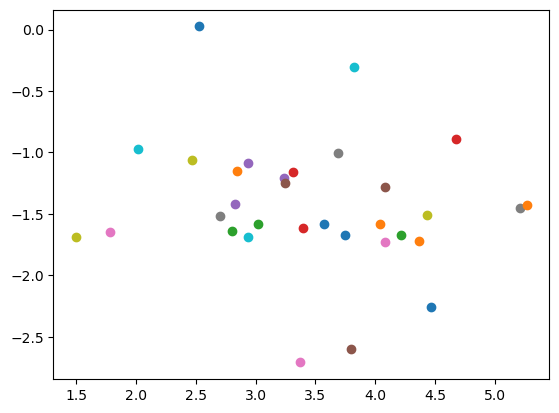

In [154]:
for x, y in zip(tmp[measured_metnames], rel_diff):
    if x < 0:
        # x = - np.log10(-x)
        x = np.nan
    else:
        x = np.log10(x)
    
    if y < 0:
        # y = - np.log10(-y)
        x = np.nan
    else:
        y = np.log10(y)
    ax = plt.scatter(x,y)

In [119]:
tmp

Metabolite
2',4'-Dihydroxyacetophenone                       14416.663333
2,3-Diaminopropionic acid                          5567.553333
2-Hydroxybutyric acid                             38903.113333
2-Hydroxyglutaric acid                           788499.343333
2-Ketobutyric acid/Succinic acid semialdehyde     23316.450000
2/3-Phosphoglyceric acid                           1039.996667
3-(2-Hydroxyphenyl)propanoic acid                 47458.776667
3-Amino-4-hydroxybenzoic acid                     25120.333333
3-Hydroxybenzoic acid                             16418.000000
3-Hydroxyphenylacetic acid                        14416.663333
4-Guanidinobutanoic acid                              0.000000
4-Hydroxyphenylpyruvic acid                         859.113333
4-Hydroxyproline                                    864.666667
4-hydroxy-L-phenylglycine                         26901.443333
Acetylglycine                                        14.890000
Adenosine 2',3'-cyclic phosphate            

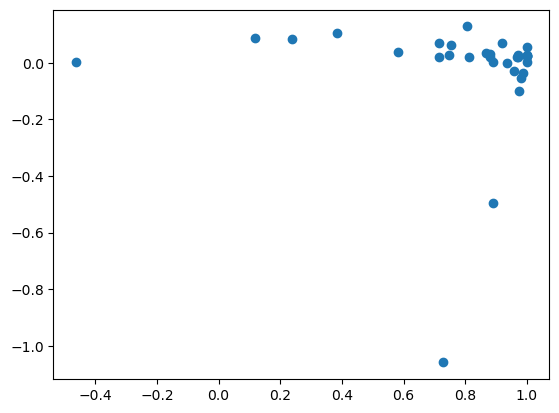

In [115]:
plt.scatter(tmp[measured_metnames], rel_diff)